# Matching

In [1]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import itertools

directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
#directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions and Maps

In [2]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV', print_peak=False):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
            if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label[i]}: {peak_bin_center:.2f} {x_units}")
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data)
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')
        if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label}: {peak_bin_center:.2f} {x_units}")

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None




mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

def duplicate_cleaner(matched_pairs, truth=None):
    truth_ids = matched_pairs['truth']['id']
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(truth_ids)])
    no_repeats = ak.num(deduped_id_pairs) == ak.num(truth_ids)
    one_repeat = ak.num(deduped_id_pairs) == ak.num(truth_ids) - 1

    duplicate_pairs = matched_pairs[one_repeat]
    clean_pairs = matched_pairs[no_repeats]
    if truth is not None:
        duplicate_truth = truth[one_repeat]
        return clean_pairs, duplicate_pairs, duplicate_truth
    
    return clean_pairs, duplicate_pairs, no_repeats

def duplicate_matcher(repeat, dupe_truth):
    fixable_repeats = repeat[ak.num(repeat)>2]

    repeat_truth, valid_particles, duplicate_particles = [], [], []

    print('going into for loop')

    for i in range(1,len(dupe_truth[0])+1):

        repeat_ids = fixable_repeats['truth']['id']
        repeat_i = fixable_repeats[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_ids_i = repeat_ids[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_truth.append(dupe_truth[ak.num(repeat_ids[repeat_ids==i], axis=1)==2])

        valid_particles.append(repeat_i[repeat_ids_i!=i])
        duplicate_particles.append(repeat_i[repeat_ids_i==i])

    print('out of for loop')

    repeat_truth = ak.concatenate(repeat_truth)
    valid_particles = [ak.concatenate(valid_particles)]
    duplicate_particles = ak.concatenate(duplicate_particles)
    id = np.tile(np.arange(1,len(repeat_truth[0])+1), (len(repeat_truth),1))
    repeat_truth_zip = ak.zip({'truth': repeat_truth, 'id': id})

    duplicate_deltars = duplicate_particles['reco'].deltaR(duplicate_particles['truth']['truth'])
    min_dupdeltars = ak.min(duplicate_deltars, axis=1)

    valid_particles.append(duplicate_particles[duplicate_deltars==min_dupdeltars])
    invalid_particles = duplicate_particles['reco'][duplicate_deltars!=min_dupdeltars]

    second_pass = ak.cartesian({'reco': invalid_particles, 'truth': repeat_truth_zip})
    second_deltars = second_pass['reco'].deltaR(second_pass['truth']['truth'])

    second_smallest_dr = ak.sort(second_deltars)[:,1]
    valid_particles.append(second_pass[(second_deltars==second_smallest_dr)&(second_smallest_dr<0.4)])
    print("pre concat")
    valid_particles = ak.concatenate(valid_particles, axis=1)
    print("post concat")
    return valid_particles

def truth_matching(truth, truth_id, reco_jets, reco_leptons):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))
    print(len(truth[0]))

    indexed_truth = ak.zip({'truth': truth, 'id': id})
    
    truth_jets = indexed_truth[truth_id < 10]
    truth_leptons = indexed_truth[(truth_id > 10)&(truth_id<20)]

    jets_3d = ak.cartesian({'reco':reco_jets, 'truth': truth_jets}, axis=1, nested=True)

    deltars = jets_3d['reco'].deltaR(jets_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_jets = ak.flatten(jets_3d[(deltars==min_deltars)&(min_deltars<0.4)], axis=2)


    leptons_3d = ak.cartesian({'truth': truth_leptons, 'reco':reco_leptons}, axis=1, nested=True)

    deltars = leptons_3d['reco'].deltaR(leptons_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_leptons = ak.flatten(leptons_3d[(deltars==min_deltars)&(min_deltars<0.1)], axis=2)

    matched = ak.concatenate((matched_jets, matched_leptons), axis=1)

    matched_pairs, repeat_pairs, matched_bools = duplicate_cleaner(matched)

    print("starting dm")

    #valid_particles = duplicate_matcher(repeat_pairs, repeat_truth)

    print("starting axis=0 concat")

    #matched_events = ak.concatenate((matched_pairs, valid_particles), axis=0)
    matched_events = matched_pairs
    
    return matched_events, matched_bools



## Data

### 4 Top Matching

In [3]:
tree4 = uproot.open(directory + "4tops_skimmed_14nov.root")
tree4_truth = tree4['Truth;1']
tree4_reco = tree4['Reco;1']

events_4t_truth = tree4_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_4t_partonic = tree4_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id'])
events_4t_reco = tree4_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_4t_reco['el_mass'] = 0.511e-3 * np.ones_like(events_4t_reco['el_pt'])
events_4t_reco['mu_mass'] = 0.1057 * np.ones_like(events_4t_reco['mu_pt'])
events_4t_reco['jet_e'] = np.sqrt(events_4t_reco['jet_mass']**2+(events_4t_reco['jet_pt']**2)*(np.cosh(events_4t_reco['jet_eta']))**2)
events_4t_reco['el_e'] = np.sqrt(events_4t_reco['el_mass']**2+(events_4t_reco['el_pt']**2)*(np.cosh(events_4t_reco['el_eta']))**2)
events_4t_reco['mu_e'] = np.sqrt(events_4t_reco['mu_mass']**2+(events_4t_reco['mu_pt']**2)*(np.cosh(events_4t_reco['mu_eta']))**2)

good_events_4t = ak.num(events_4t_truth['b_id']) == 4

invalid_events_4t_truth = events_4t_truth[~good_events_4t]
invalid_events_4t_truth['b_id'], invalid_events_4t_truth['b_pt'], invalid_events_4t_truth['b_eta'] = invalid_events_4t_truth['b_id'][:,1:], invalid_events_4t_truth['b_pt'][:,1:], invalid_events_4t_truth['b_eta'][:,1:]
invalid_events_4t_truth['b_phi'], invalid_events_4t_truth['b_e'], invalid_events_4t_truth['b_mass'] = invalid_events_4t_truth['b_phi'][:,1:], invalid_events_4t_truth['b_e'][:,1:], invalid_events_4t_truth['b_mass'][:,1:]

events_4t_truth = ak.concatenate((events_4t_truth[good_events_4t], invalid_events_4t_truth))
events_4t_reco = ak.concatenate((events_4t_reco[good_events_4t], events_4t_reco[~good_events_4t]))
events_4t_partonic = ak.concatenate((events_4t_partonic[good_events_4t], events_4t_partonic[~good_events_4t]))

x = events_4t_truth['W_decay_id'][(events_4t_truth['W_decay_id']==15)|(events_4t_truth['W_decay_id']==-15)]
events_4t_reco = events_4t_reco[ak.num(x)==0]
events_4t_partonic = events_4t_partonic[ak.num(x)==0]
events_4t_truth = events_4t_truth[ak.num(x)==0]

neutrino_remover = (abs(events_4t_truth['W_decay_id']) != 12)&(abs(events_4t_truth['W_decay_id']) != 14)&(abs(events_4t_truth['W_decay_id']) != 16)&(abs(events_4t_truth['W_decay_id']) != 18)
events_4t_truth['W_decay_id'] = events_4t_truth['W_decay_id'][neutrino_remover]
events_4t_truth['W_decay_pt'] = events_4t_truth['W_decay_pt'][neutrino_remover]
events_4t_truth['W_decay_eta'] = events_4t_truth['W_decay_eta'][neutrino_remover]
events_4t_truth['W_decay_phi'] = events_4t_truth['W_decay_phi'][neutrino_remover]
events_4t_truth['W_decay_e'] = events_4t_truth['W_decay_e'][neutrino_remover]
events_4t_truth['W_decay_mass'] = events_4t_truth['W_decay_mass'][neutrino_remover]

jet_pt_4t = events_4t_reco['jet_pt'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_eta_4t = events_4t_reco['jet_eta'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_phi_4t = events_4t_reco['jet_phi'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_mass_4t = events_4t_reco['jet_mass'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_e_4t = events_4t_reco['jet_e'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]

electron_pt_4t = events_4t_reco['el_pt'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_eta_4t = events_4t_reco['el_eta'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_phi_4t = events_4t_reco['el_phi'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_mass_4t = events_4t_reco['el_mass'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_e_4t = events_4t_reco['el_e'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]

muon_pt_4t = events_4t_reco['mu_pt'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_eta_4t = events_4t_reco['mu_eta'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_phi_4t = events_4t_reco['mu_phi'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_mass_4t = events_4t_reco['mu_mass'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_e_4t = events_4t_reco['mu_e'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]

lepton_pt_4t = ak.concatenate((muon_pt_4t,electron_pt_4t), axis=1)
lepton_eta_4t = ak.concatenate((muon_eta_4t,electron_eta_4t), axis=1)
lepton_phi_4t = ak.concatenate((muon_phi_4t,electron_phi_4t), axis=1)
lepton_mass_4t = ak.concatenate((muon_mass_4t,electron_mass_4t), axis=1)
lepton_e_4t = ak.concatenate((muon_e_4t,electron_e_4t), axis=1)

reco_pt_4t = ak.concatenate((jet_pt_4t,lepton_pt_4t), axis=1)
reco_eta_4t = ak.concatenate((jet_eta_4t,lepton_eta_4t), axis=1)
reco_phi_4t = ak.concatenate((jet_phi_4t,lepton_phi_4t), axis=1)
reco_mass_4t = ak.concatenate((jet_mass_4t,lepton_mass_4t), axis=1)
reco_e_4t = ak.concatenate((jet_e_4t,lepton_e_4t), axis=1)

b_pt_4t = events_4t_truth['b_pt']
b_eta_4t = events_4t_truth['b_eta']
b_phi_4t = events_4t_truth['b_phi']
b_mass_4t = events_4t_truth['b_mass']
b_e_4t = events_4t_truth['b_e']
b_id_4t = events_4t_truth['b_id']

w_decay_pt_4t = events_4t_truth['W_decay_pt']
w_decay_eta_4t = events_4t_truth['W_decay_eta']
w_decay_phi_4t = events_4t_truth['W_decay_phi']
w_decay_mass_4t = events_4t_truth['W_decay_mass']
w_decay_e_4t = events_4t_truth['W_decay_e']
w_decay_id_4t = events_4t_truth['W_decay_id']

truth_pt_4t = ak.concatenate((b_pt_4t,w_decay_pt_4t), axis=1)
truth_eta_4t = ak.concatenate((b_eta_4t,w_decay_eta_4t), axis=1)
truth_phi_4t = ak.concatenate((b_phi_4t,w_decay_phi_4t), axis=1)
truth_mass_4t = ak.concatenate((b_mass_4t,w_decay_mass_4t), axis=1)
truth_e_4t = ak.concatenate((b_e_4t,w_decay_e_4t), axis=1)
truth_id_4t = ak.concatenate((b_id_4t,w_decay_id_4t), axis=1)

reco_4t = vector.zip({'pt':reco_pt_4t,'eta':reco_eta_4t,'phi':reco_phi_4t,'energy':reco_e_4t})
truth_4t = vector.zip({'pt':truth_pt_4t,'eta':truth_eta_4t,'phi':truth_phi_4t,'energy':truth_e_4t})

reco_4t_leptons = vector.zip({'pt':lepton_pt_4t,'eta':lepton_eta_4t,'phi':lepton_phi_4t,'energy':lepton_e_4t})
reco_4t_jets = vector.zip({'pt':jet_pt_4t,'eta':jet_eta_4t,'phi':jet_phi_4t,'energy':jet_e_4t})

truth_4t = truth_4t[(ak.num(reco_4t)!=0)]
reco_4t = reco_4t[(ak.num(reco_4t)!=0)]
reco_4t_leptons = reco_4t_leptons[(ak.num(reco_4t)!=0)]
reco_4t_jets = reco_4t_jets[(ak.num(reco_4t)!=0)]


## Top Identifier Function

In [36]:
def top_identifier(matched_data, process, top_channel, lepton_channel, lepton_indices=None, at_least=False):
    """
    Takes the matched, duplicate free data and trys to reconstruct any tops it can
    """

    if process=="4t":
        if lepton_channel == "0L":
            tops_1 = matched_data[(matched_data['truth']['id']==1)|(matched_data['truth']['id']==5)|(matched_data['truth']['id']==6)]
            tops_2 = matched_data[(matched_data['truth']['id']==2)|(matched_data['truth']['id']==7)|(matched_data['truth']['id']==8)]
            tops_3 = matched_data[(matched_data['truth']['id']==3)|(matched_data['truth']['id']==9)|(matched_data['truth']['id']==10)]
            tops_4 = matched_data[(matched_data['truth']['id']==4)|(matched_data['truth']['id']==11)|(matched_data['truth']['id']==12)]

            if top_channel == 'sm':

                if at_least:
                    matched_tops_1 = tops_1[(ak.num(tops_1)==3)]
                    matched_tops_2 = tops_2[(ak.num(tops_2)==3)]
                    matched_tops_3 = tops_3[(ak.num(tops_3)==3)]
                    matched_tops_4 = tops_4[(ak.num(tops_4)==3)]

                else:
                    matched_tops_1 = tops_1[(ak.num(tops_1)==3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)!=3)&(ak.num(tops_4)!=3)]
                    matched_tops_2 = tops_2[(ak.num(tops_1)!=3)&(ak.num(tops_2)==3)&(ak.num(tops_3)!=3)&(ak.num(tops_4)!=3)]
                    matched_tops_3 = tops_3[(ak.num(tops_1)!=3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)==3)&(ak.num(tops_4)!=3)]
                    matched_tops_4 = tops_4[(ak.num(tops_1)!=3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)!=3)&(ak.num(tops_4)==3)]


                truth_top_1 = ak.sum(matched_tops_1['truth']['truth'][(matched_tops_1['truth']['id']==1)|(matched_tops_1['truth']['id']==5)|(matched_tops_1['truth']['id']==6)], axis=1)
                truth_top_2 = ak.sum(matched_tops_2['truth']['truth'][(matched_tops_2['truth']['id']==2)|(matched_tops_2['truth']['id']==7)|(matched_tops_2['truth']['id']==8)], axis=1)
                truth_top_3 = ak.sum(matched_tops_3['truth']['truth'][(matched_tops_3['truth']['id']==3)|(matched_tops_3['truth']['id']==9)|(matched_tops_3['truth']['id']==10)], axis=1)
                truth_top_4 = ak.sum(matched_tops_4['truth']['truth'][(matched_tops_4['truth']['id']==4)|(matched_tops_4['truth']['id']==11)|(matched_tops_4['truth']['id']==12)], axis=1)

                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4))

                reco_top_1 = ak.sum(matched_tops_1['reco'][(matched_tops_1['truth']['id']==1)|(matched_tops_1['truth']['id']==5)|(matched_tops_1['truth']['id']==6)], axis=1)
                reco_top_2 = ak.sum(matched_tops_2['reco'][(matched_tops_2['truth']['id']==2)|(matched_tops_2['truth']['id']==7)|(matched_tops_2['truth']['id']==8)], axis=1)
                reco_top_3 = ak.sum(matched_tops_3['reco'][(matched_tops_3['truth']['id']==3)|(matched_tops_3['truth']['id']==9)|(matched_tops_3['truth']['id']==10)], axis=1)
                reco_top_4 = ak.sum(matched_tops_4['reco'][(matched_tops_4['truth']['id']==4)|(matched_tops_4['truth']['id']==11)|(matched_tops_4['truth']['id']==12)], axis=1)

                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4))

                return sm_truth_tops, sm_reco_tops

            elif top_channel == 'fm':

                fully_matched_events = matched_data[(ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3)]
                truth_top_1 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==5)|(fully_matched_events['truth']['id']==6)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==7)|(fully_matched_events['truth']['id']==8)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==9)|(fully_matched_events['truth']['id']==10)], axis=1),1)
                truth_top_4 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==11)|(fully_matched_events['truth']['id']==12)], axis=1),1)

                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==5)|(fully_matched_events['truth']['id']==6)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==7)|(fully_matched_events['truth']['id']==8)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==9)|(fully_matched_events['truth']['id']==10)], axis=1),1)
                reco_top_4 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==11)|(fully_matched_events['truth']['id']==12)], axis=1),1)

                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1)

                return fm_truth_tops, fm_reco_tops

            elif top_channel == 'tm':
                triple_matched_events_123 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_3)==3))&(ak.num(matched_data)<12)]
                tm_123_truth_top_1 = ak.sum(triple_matched_events_123['truth']['truth'][(triple_matched_events_123['truth']['id']==1)|(triple_matched_events_123['truth']['id']==5)|(triple_matched_events_123['truth']['id']==6)], axis=1)
                tm_123_truth_top_2 = ak.sum(triple_matched_events_123['truth']['truth'][(triple_matched_events_123['truth']['id']==2)|(triple_matched_events_123['truth']['id']==7)|(triple_matched_events_123['truth']['id']==8)], axis=1)
                tm_123_truth_top_3 = ak.sum(triple_matched_events_123['truth']['truth'][(triple_matched_events_123['truth']['id']==3)|(triple_matched_events_123['truth']['id']==9)|(triple_matched_events_123['truth']['id']==10)], axis=1)

                tm_123_reco_top_1 = ak.sum(triple_matched_events_123['reco'][(triple_matched_events_123['truth']['id']==1)|(triple_matched_events_123['truth']['id']==5)|(triple_matched_events_123['truth']['id']==6)], axis=1)
                tm_123_reco_top_2 = ak.sum(triple_matched_events_123['reco'][(triple_matched_events_123['truth']['id']==2)|(triple_matched_events_123['truth']['id']==7)|(triple_matched_events_123['truth']['id']==8)], axis=1)
                tm_123_reco_top_3 = ak.sum(triple_matched_events_123['reco'][(triple_matched_events_123['truth']['id']==3)|(triple_matched_events_123['truth']['id']==9)|(triple_matched_events_123['truth']['id']==10)], axis=1)

                triple_matched_events_124 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_4)==3))&(ak.num(matched_data)<12)]
                tm_124_truth_top_1 = ak.sum(triple_matched_events_124['truth']['truth'][(triple_matched_events_124['truth']['id']==1)|(triple_matched_events_124['truth']['id']==5)|(triple_matched_events_124['truth']['id']==6)], axis=1)
                tm_124_truth_top_2 = ak.sum(triple_matched_events_124['truth']['truth'][(triple_matched_events_124['truth']['id']==2)|(triple_matched_events_124['truth']['id']==7)|(triple_matched_events_124['truth']['id']==8)], axis=1)
                tm_124_truth_top_3 = ak.sum(triple_matched_events_124['truth']['truth'][(triple_matched_events_124['truth']['id']==4)|(triple_matched_events_124['truth']['id']==11)|(triple_matched_events_124['truth']['id']==12)], axis=1)

                tm_124_reco_top_1 = ak.sum(triple_matched_events_124['reco'][(triple_matched_events_124['truth']['id']==1)|(triple_matched_events_124['truth']['id']==5)|(triple_matched_events_124['truth']['id']==6)], axis=1)
                tm_124_reco_top_2 = ak.sum(triple_matched_events_124['reco'][(triple_matched_events_124['truth']['id']==2)|(triple_matched_events_124['truth']['id']==7)|(triple_matched_events_124['truth']['id']==8)], axis=1)
                tm_124_reco_top_3 = ak.sum(triple_matched_events_124['reco'][(triple_matched_events_124['truth']['id']==4)|(triple_matched_events_124['truth']['id']==11)|(triple_matched_events_124['truth']['id']==12)], axis=1)

                triple_matched_events_134 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3))&(ak.num(matched_data)<12)]
                tm_134_truth_top_1 = ak.sum(triple_matched_events_134['truth']['truth'][(triple_matched_events_134['truth']['id']==1)|(triple_matched_events_134['truth']['id']==5)|(triple_matched_events_134['truth']['id']==6)], axis=1)
                tm_134_truth_top_2 = ak.sum(triple_matched_events_134['truth']['truth'][(triple_matched_events_134['truth']['id']==3)|(triple_matched_events_134['truth']['id']==9)|(triple_matched_events_134['truth']['id']==10)], axis=1)
                tm_134_truth_top_3 = ak.sum(triple_matched_events_134['truth']['truth'][(triple_matched_events_134['truth']['id']==4)|(triple_matched_events_134['truth']['id']==11)|(triple_matched_events_134['truth']['id']==12)], axis=1)

                tm_134_reco_top_1 = ak.sum(triple_matched_events_134['reco'][(triple_matched_events_134['truth']['id']==1)|(triple_matched_events_134['truth']['id']==5)|(triple_matched_events_134['truth']['id']==6)], axis=1)
                tm_134_reco_top_2 = ak.sum(triple_matched_events_134['reco'][(triple_matched_events_134['truth']['id']==3)|(triple_matched_events_134['truth']['id']==9)|(triple_matched_events_134['truth']['id']==10)], axis=1)
                tm_134_reco_top_3 = ak.sum(triple_matched_events_134['reco'][(triple_matched_events_134['truth']['id']==4)|(triple_matched_events_134['truth']['id']==11)|(triple_matched_events_134['truth']['id']==12)], axis=1)

                triple_matched_events_234 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3))&(ak.num(matched_data)<12)]
                tm_234_truth_top_1 = ak.sum(triple_matched_events_234['truth']['truth'][(triple_matched_events_234['truth']['id']==2)|(triple_matched_events_234['truth']['id']==7)|(triple_matched_events_234['truth']['id']==8)], axis=1)
                tm_234_truth_top_2 = ak.sum(triple_matched_events_234['truth']['truth'][(triple_matched_events_234['truth']['id']==3)|(triple_matched_events_234['truth']['id']==9)|(triple_matched_events_234['truth']['id']==10)], axis=1)
                tm_234_truth_top_3 = ak.sum(triple_matched_events_234['truth']['truth'][(triple_matched_events_234['truth']['id']==4)|(triple_matched_events_234['truth']['id']==11)|(triple_matched_events_234['truth']['id']==12)], axis=1)

                tm_234_reco_top_1 = ak.sum(triple_matched_events_234['reco'][(triple_matched_events_234['truth']['id']==2)|(triple_matched_events_234['truth']['id']==7)|(triple_matched_events_234['truth']['id']==8)], axis=1)
                tm_234_reco_top_2 = ak.sum(triple_matched_events_234['reco'][(triple_matched_events_234['truth']['id']==3)|(triple_matched_events_234['truth']['id']==9)|(triple_matched_events_234['truth']['id']==10)], axis=1)
                tm_234_reco_top_3 = ak.sum(triple_matched_events_234['reco'][(triple_matched_events_234['truth']['id']==4)|(triple_matched_events_234['truth']['id']==11)|(triple_matched_events_234['truth']['id']==12)], axis=1)

                tm_truth_top_1 = ak.unflatten(ak.concatenate((tm_123_truth_top_1, tm_124_truth_top_1, tm_134_truth_top_1, tm_234_truth_top_1)),1)
                tm_truth_top_2 = ak.unflatten(ak.concatenate((tm_123_truth_top_2, tm_124_truth_top_2, tm_134_truth_top_2, tm_234_truth_top_2)),1)
                tm_truth_top_3 = ak.unflatten(ak.concatenate((tm_123_truth_top_3, tm_124_truth_top_3, tm_134_truth_top_3, tm_234_truth_top_3)),1)
                tm_truth_tops = ak.concatenate((tm_truth_top_1,tm_truth_top_2,tm_truth_top_3), axis=1)

                tm_reco_top_1 = ak.unflatten(ak.concatenate((tm_123_reco_top_1, tm_124_reco_top_1, tm_134_reco_top_1, tm_234_reco_top_1)),1)
                tm_reco_top_2 = ak.unflatten(ak.concatenate((tm_123_reco_top_2, tm_124_reco_top_2, tm_134_reco_top_2, tm_234_reco_top_2)),1)
                tm_reco_top_3 = ak.unflatten(ak.concatenate((tm_123_reco_top_3, tm_124_reco_top_3, tm_134_reco_top_3, tm_234_reco_top_3)),1)
                tm_reco_tops = ak.concatenate((tm_reco_top_1,tm_reco_top_2,tm_reco_top_3), axis=1)

                return tm_truth_tops, tm_reco_tops

            elif top_channel=='dm':
                double_matched_events_12 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3))&((ak.num(tops_3)!=3)&(ak.num(tops_4)!=3))]
                dm_truth_12_tops_1 = ak.sum(double_matched_events_12['truth']['truth'][(double_matched_events_12['truth']['id']==1)|(double_matched_events_12['truth']['id']==5)|(double_matched_events_12['truth']['id']==6)], axis=1)
                dm_truth_12_tops_2 = ak.sum(double_matched_events_12['truth']['truth'][(double_matched_events_12['truth']['id']==2)|(double_matched_events_12['truth']['id']==7)|(double_matched_events_12['truth']['id']==8)], axis=1)

                dm_reco_12_tops_1 = ak.sum(double_matched_events_12['reco'][(double_matched_events_12['truth']['id']==1)|(double_matched_events_12['truth']['id']==5)|(double_matched_events_12['truth']['id']==6)], axis=1)
                dm_reco_12_tops_2 = ak.sum(double_matched_events_12['reco'][(double_matched_events_12['truth']['id']==2)|(double_matched_events_12['truth']['id']==7)|(double_matched_events_12['truth']['id']==8)], axis=1)

                double_matched_events_13 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_3)==3))&((ak.num(tops_2)!=3)&(ak.num(tops_4)!=3))]
                dm_truth_13_tops_1 = ak.sum(double_matched_events_13['truth']['truth'][(double_matched_events_13['truth']['id']==1)|(double_matched_events_13['truth']['id']==5)|(double_matched_events_13['truth']['id']==6)], axis=1)
                dm_truth_13_tops_2 = ak.sum(double_matched_events_13['truth']['truth'][(double_matched_events_13['truth']['id']==3)|(double_matched_events_13['truth']['id']==9)|(double_matched_events_13['truth']['id']==10)], axis=1)

                dm_reco_13_tops_1 = ak.sum(double_matched_events_13['reco'][(double_matched_events_13['truth']['id']==1)|(double_matched_events_13['truth']['id']==5)|(double_matched_events_13['truth']['id']==6)], axis=1)
                dm_reco_13_tops_2 = ak.sum(double_matched_events_13['reco'][(double_matched_events_13['truth']['id']==3)|(double_matched_events_13['truth']['id']==9)|(double_matched_events_13['truth']['id']==10)], axis=1)

                double_matched_events_14 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_4)==3))&((ak.num(tops_2)!=3)&(ak.num(tops_3)!=3))]
                dm_truth_14_tops_1 = ak.sum(double_matched_events_14['truth']['truth'][(double_matched_events_14['truth']['id']==1)|(double_matched_events_14['truth']['id']==5)|(double_matched_events_14['truth']['id']==6)], axis=1)
                dm_truth_14_tops_2 = ak.sum(double_matched_events_14['truth']['truth'][(double_matched_events_14['truth']['id']==4)|(double_matched_events_14['truth']['id']==11)|(double_matched_events_14['truth']['id']==12)], axis=1)

                dm_reco_14_tops_1 = ak.sum(double_matched_events_14['reco'][(double_matched_events_14['truth']['id']==1)|(double_matched_events_14['truth']['id']==5)|(double_matched_events_14['truth']['id']==6)], axis=1)
                dm_reco_14_tops_2 = ak.sum(double_matched_events_14['reco'][(double_matched_events_14['truth']['id']==4)|(double_matched_events_14['truth']['id']==11)|(double_matched_events_14['truth']['id']==12)], axis=1)

                double_matched_events_23 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_3)==3))&((ak.num(tops_1)!=3)&(ak.num(tops_4)!=3))]
                dm_truth_23_tops_1 = ak.sum(double_matched_events_23['truth']['truth'][(double_matched_events_23['truth']['id']==2)|(double_matched_events_23['truth']['id']==7)|(double_matched_events_23['truth']['id']==8)], axis=1)
                dm_truth_23_tops_2 = ak.sum(double_matched_events_23['truth']['truth'][(double_matched_events_23['truth']['id']==3)|(double_matched_events_23['truth']['id']==9)|(double_matched_events_23['truth']['id']==10)], axis=1)

                dm_reco_23_tops_1 = ak.sum(double_matched_events_23['reco'][(double_matched_events_23['truth']['id']==2)|(double_matched_events_23['truth']['id']==7)|(double_matched_events_23['truth']['id']==8)], axis=1)
                dm_reco_23_tops_2 = ak.sum(double_matched_events_23['reco'][(double_matched_events_23['truth']['id']==3)|(double_matched_events_23['truth']['id']==9)|(double_matched_events_23['truth']['id']==10)], axis=1)

                double_matched_events_24 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_4)==3))&((ak.num(tops_1)!=3)&(ak.num(tops_3)!=3))]
                dm_truth_24_tops_1 = ak.sum(double_matched_events_24['truth']['truth'][(double_matched_events_24['truth']['id']==2)|(double_matched_events_24['truth']['id']==7)|(double_matched_events_24['truth']['id']==8)], axis=1)
                dm_truth_24_tops_2 = ak.sum(double_matched_events_24['truth']['truth'][(double_matched_events_24['truth']['id']==4)|(double_matched_events_24['truth']['id']==11)|(double_matched_events_24['truth']['id']==12)], axis=1)

                dm_reco_24_tops_1 = ak.sum(double_matched_events_24['reco'][(double_matched_events_24['truth']['id']==2)|(double_matched_events_24['truth']['id']==7)|(double_matched_events_24['truth']['id']==8)], axis=1)
                dm_reco_24_tops_2 = ak.sum(double_matched_events_24['reco'][(double_matched_events_24['truth']['id']==4)|(double_matched_events_24['truth']['id']==11)|(double_matched_events_24['truth']['id']==12)], axis=1)

                double_matched_events_34 = matched_data[((ak.num(tops_3)==3)&(ak.num(tops_4)==3))&((ak.num(tops_1)!=3)&(ak.num(tops_2)!=3))]
                dm_truth_34_tops_1 = ak.sum(double_matched_events_34['truth']['truth'][(double_matched_events_34['truth']['id']==3)|(double_matched_events_34['truth']['id']==9)|(double_matched_events_34['truth']['id']==10)], axis=1)
                dm_truth_34_tops_2 = ak.sum(double_matched_events_34['truth']['truth'][(double_matched_events_34['truth']['id']==4)|(double_matched_events_34['truth']['id']==11)|(double_matched_events_34['truth']['id']==12)], axis=1)

                dm_reco_34_tops_1 = ak.sum(double_matched_events_34['reco'][(double_matched_events_34['truth']['id']==3)|(double_matched_events_34['truth']['id']==9)|(double_matched_events_34['truth']['id']==10)], axis=1)
                dm_reco_34_tops_2 = ak.sum(double_matched_events_34['reco'][(double_matched_events_34['truth']['id']==4)|(double_matched_events_34['truth']['id']==11)|(double_matched_events_34['truth']['id']==12)], axis=1)

                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_truth_12_tops_1,dm_truth_13_tops_1,dm_truth_14_tops_1,dm_truth_23_tops_1,dm_truth_24_tops_1,dm_truth_34_tops_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_truth_12_tops_2,dm_truth_13_tops_2,dm_truth_14_tops_2,dm_truth_23_tops_2,dm_truth_24_tops_2,dm_truth_34_tops_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)

                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_reco_12_tops_1,dm_reco_13_tops_1,dm_reco_14_tops_1,dm_reco_23_tops_1,dm_reco_24_tops_1,dm_reco_34_tops_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_reco_12_tops_2,dm_reco_13_tops_2,dm_reco_14_tops_2,dm_reco_23_tops_2,dm_reco_24_tops_2,dm_reco_34_tops_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)

                return dm_truth_tops, dm_reco_tops
        
        elif lepton_channel == "1L":

            print(len(matched_data[ak.num(matched_data)==11]))

            matched_0 = matched_data[(lepton_indices[:,0]==0)]
            t1_0_truth_lepton = matched_0['truth']['truth'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==5)]
            t1_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==6)|(matched_0['truth']['id']==7)]
            t2_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==8)|(matched_0['truth']['id']==9)]
            t3_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==4)|(matched_0['truth']['id']==10)|(matched_0['truth']['id']==11)]

            t1_0_reco_lepton = matched_0['reco'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==5)]
            t1_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==6)|(matched_0['truth']['id']==7)]
            t2_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==8)|(matched_0['truth']['id']==9)]
            t3_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==4)|(matched_0['truth']['id']==10)|(matched_0['truth']['id']==11)]

            matched_2 = matched_data[(lepton_indices[:,0]==2)]
            t1_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==5)|(matched_2['truth']['id']==6)]
            t1_2_truth_lepton = matched_2['truth']['truth'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==7)]
            t2_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==8)|(matched_2['truth']['id']==9)]
            t3_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==4)|(matched_2['truth']['id']==10)|(matched_2['truth']['id']==11)]

            t1_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==5)|(matched_2['truth']['id']==6)]
            t1_2_reco_lepton = matched_2['reco'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==7)]
            t2_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==8)|(matched_2['truth']['id']==9)]
            t3_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==4)|(matched_2['truth']['id']==10)|(matched_2['truth']['id']==11)]

            matched_4 = matched_data[(lepton_indices[:,0]==4)]
            t1_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==5)|(matched_4['truth']['id']==6)]
            t2_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==7)|(matched_4['truth']['id']==8)]
            t1_4_truth_lepton = matched_4['truth']['truth'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==9)]
            t3_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==4)|(matched_4['truth']['id']==10)|(matched_4['truth']['id']==11)]

            t1_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==5)|(matched_4['truth']['id']==6)]
            t2_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==7)|(matched_4['truth']['id']==8)]
            t1_4_reco_lepton = matched_4['reco'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==9)]
            t3_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==4)|(matched_4['truth']['id']==10)|(matched_4['truth']['id']==11)]

            matched_6 = matched_data[(lepton_indices[:,0]==6)]
            t1_6_truth_jet = matched_6['truth']['truth'][(matched_6['truth']['id']==1)|(matched_6['truth']['id']==5)|(matched_6['truth']['id']==6)]
            t2_6_truth_jet = matched_6['truth']['truth'][(matched_6['truth']['id']==2)|(matched_6['truth']['id']==7)|(matched_6['truth']['id']==8)]
            t3_6_truth_jet = matched_6['truth']['truth'][(matched_6['truth']['id']==3)|(matched_6['truth']['id']==9)|(matched_6['truth']['id']==10)]
            t1_6_truth_lepton = matched_6['truth']['truth'][(matched_6['truth']['id']==4)|(matched_6['truth']['id']==11)]

            t1_6_reco_jet = matched_6['reco'][(matched_6['truth']['id']==1)|(matched_6['truth']['id']==5)|(matched_6['truth']['id']==6)]
            t2_6_reco_jet = matched_6['reco'][(matched_6['truth']['id']==2)|(matched_6['truth']['id']==7)|(matched_6['truth']['id']==8)]
            t3_6_reco_jet = matched_6['reco'][(matched_6['truth']['id']==3)|(matched_6['truth']['id']==9)|(matched_6['truth']['id']==10)]
            t1_6_reco_lepton = matched_6['reco'][(matched_6['truth']['id']==4)|(matched_6['truth']['id']==11)]

            truth_t1_lepton = ak.concatenate((t1_0_truth_lepton,t1_2_truth_lepton, t1_4_truth_lepton, t1_6_truth_lepton))
            truth_t1_jet = ak.concatenate((t1_0_truth_jet,t1_2_truth_jet, t1_4_truth_jet, t1_6_truth_jet))
            truth_t2_jet = ak.concatenate((t2_0_truth_jet,t2_2_truth_jet, t2_4_truth_jet, t2_6_truth_jet))
            truth_t3_jet = ak.concatenate((t3_0_truth_jet,t3_2_truth_jet, t3_4_truth_jet, t3_6_truth_jet))

            reco_t1_lepton = ak.concatenate((t1_0_reco_lepton,t1_2_reco_lepton, t1_4_reco_lepton, t1_6_reco_lepton))
            reco_t1_jet = ak.concatenate((t1_0_reco_jet,t1_2_reco_jet, t1_4_reco_jet, t1_6_reco_jet))
            reco_t2_jet = ak.concatenate((t2_0_reco_jet,t2_2_reco_jet, t2_4_reco_jet, t2_6_reco_jet))
            reco_t3_jet = ak.concatenate((t3_0_reco_jet,t3_2_reco_jet, t3_4_reco_jet, t3_6_reco_jet))

            if top_channel == 'sm':
                if at_least:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)], axis=1)
                    reco_top_2 = ak.sum(reco_t1_jet[(ak.num(reco_t1_jet)==3)], axis=1)
                    reco_top_3 = ak.sum(reco_t2_jet[(ak.num(reco_t2_jet)==3)], axis=1)
                    reco_top_4 = ak.sum(reco_t3_jet[(ak.num(reco_t3_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)], axis=1)
                    truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_jet)==3)], axis=1)
                    truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t2_jet)==3)], axis=1)
                    truth_top_4 = ak.sum(truth_t3_jet[(ak.num(truth_t3_jet)==3)], axis=1)
                else:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)&(ak.num(reco_t3_jet)!=3)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_2 = ak.sum(reco_t1_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t3_jet)==3)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_3 = ak.sum(reco_t2_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t3_jet)!=3)&(ak.num(reco_t1_jet)==3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_4 = ak.sum(reco_t3_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t3_jet)!=3)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_4 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                
                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4))
                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4))
                return sm_truth_tops, sm_reco_tops
            
            elif top_channel == 'fm':
                truth_top_1 = ak.unflatten(ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_4 = ak.unflatten(ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_4 = ak.unflatten(ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1)

                return fm_truth_tops, fm_reco_tops
            
            elif top_channel == 'tm':
                
                tm_123_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_truth_top_2 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_2 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                tm_124_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_truth_top_2 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_2 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_134_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_234_truth_top_1 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_1 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_truth_top_1 = ak.unflatten(ak.concatenate((tm_123_truth_top_1, tm_124_truth_top_1, tm_134_truth_top_1, tm_234_truth_top_1)),1)
                tm_truth_top_2 = ak.unflatten(ak.concatenate((tm_123_truth_top_2, tm_124_truth_top_2, tm_134_truth_top_2, tm_234_truth_top_2)),1)
                tm_truth_top_3 = ak.unflatten(ak.concatenate((tm_123_truth_top_3, tm_124_truth_top_3, tm_134_truth_top_3, tm_234_truth_top_3)),1)
                tm_truth_tops = ak.concatenate((tm_truth_top_1,tm_truth_top_2,tm_truth_top_3), axis=1)

                tm_reco_top_1 = ak.unflatten(ak.concatenate((tm_123_reco_top_1, tm_124_reco_top_1, tm_134_reco_top_1, tm_234_reco_top_1)),1)
                tm_reco_top_2 = ak.unflatten(ak.concatenate((tm_123_reco_top_2, tm_124_reco_top_2, tm_134_reco_top_2, tm_234_reco_top_2)),1)
                tm_reco_top_3 = ak.unflatten(ak.concatenate((tm_123_reco_top_3, tm_124_reco_top_3, tm_134_reco_top_3, tm_234_reco_top_3)),1)
                tm_reco_tops = ak.concatenate((tm_reco_top_1,tm_reco_top_2,tm_reco_top_3), axis=1)

                return tm_truth_tops, tm_reco_tops
            
            elif top_channel=='dm':
                
                dm_12_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_truth_top_2 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_12_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_reco_top_2 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_13_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_13_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_14_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_14_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_14_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_14_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_23_truth_top_1 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_23_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_23_reco_top_1 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_23_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_24_truth_top_1 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_24_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_24_reco_top_1 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_24_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_34_truth_top_1 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_34_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_34_reco_top_1 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_34_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)


                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_12_truth_top_1,dm_13_truth_top_1,dm_14_truth_top_1,dm_23_truth_top_1,dm_24_truth_top_1,dm_34_truth_top_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_12_truth_top_2,dm_13_truth_top_2,dm_14_truth_top_2,dm_23_truth_top_2,dm_24_truth_top_2,dm_34_truth_top_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)
                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_12_reco_top_1,dm_13_reco_top_1,dm_14_reco_top_1,dm_23_reco_top_1,dm_24_reco_top_1,dm_34_reco_top_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_12_reco_top_2,dm_13_reco_top_2,dm_14_reco_top_2,dm_23_reco_top_2,dm_24_reco_top_2,dm_34_reco_top_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)
                return dm_truth_tops, dm_reco_tops


            
        elif lepton_channel == "2L":

            matched_01 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
            t1_01_truth_lepton = matched_01['truth']['truth'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==5)]
            t2_01_truth_lepton = matched_01['truth']['truth'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==6)]
            t1_01_truth_jet = matched_01['truth']['truth'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==7)|(matched_01['truth']['id']==8)]
            t2_01_truth_jet = matched_01['truth']['truth'][(matched_01['truth']['id']==4)|(matched_01['truth']['id']==9)|(matched_01['truth']['id']==10)]

            t1_01_reco_lepton = matched_01['reco'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==5)]
            t2_01_reco_lepton = matched_01['reco'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==6)]
            t1_01_reco_jet = matched_01['reco'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==7)|(matched_01['truth']['id']==8)]
            t2_01_reco_jet = matched_01['reco'][(matched_01['truth']['id']==4)|(matched_01['truth']['id']==9)|(matched_01['truth']['id']==10)]

            matched_03 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
            t1_03_truth_lepton = matched_03['truth']['truth'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==5)]
            t1_03_truth_jet = matched_03['truth']['truth'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==6)|(matched_03['truth']['id']==7)]
            t2_03_truth_lepton = matched_03['truth']['truth'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==8)]
            t2_03_truth_jet = matched_03['truth']['truth'][(matched_03['truth']['id']==4)|(matched_03['truth']['id']==9)|(matched_03['truth']['id']==10)]

            t1_03_reco_lepton = matched_03['reco'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==5)]
            t1_03_reco_jet = matched_03['reco'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==6)|(matched_03['truth']['id']==7)]
            t2_03_reco_lepton = matched_03['reco'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==8)]
            t2_03_reco_jet = matched_03['reco'][(matched_03['truth']['id']==4)|(matched_03['truth']['id']==9)|(matched_03['truth']['id']==10)]

            matched_05 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==5)]
            t1_05_truth_lepton = matched_05['truth']['truth'][(matched_05['truth']['id']==1)|(matched_05['truth']['id']==5)]
            t1_05_truth_jet = matched_05['truth']['truth'][(matched_05['truth']['id']==2)|(matched_05['truth']['id']==6)|(matched_05['truth']['id']==7)]
            t2_05_truth_jet = matched_05['truth']['truth'][(matched_05['truth']['id']==3)|(matched_05['truth']['id']==8)|(matched_05['truth']['id']==9)]
            t2_05_truth_lepton = matched_05['truth']['truth'][(matched_05['truth']['id']==4)|(matched_05['truth']['id']==10)]

            t1_05_reco_lepton = matched_05['reco'][(matched_05['truth']['id']==1)|(matched_05['truth']['id']==5)]
            t1_05_reco_jet = matched_05['reco'][(matched_05['truth']['id']==2)|(matched_05['truth']['id']==6)|(matched_05['truth']['id']==7)]
            t2_05_reco_jet = matched_05['reco'][(matched_05['truth']['id']==3)|(matched_05['truth']['id']==8)|(matched_05['truth']['id']==9)]
            t2_05_reco_lepton = matched_05['reco'][(matched_05['truth']['id']==4)|(matched_05['truth']['id']==10)]

            matched_23 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
            t1_23_truth_jet = matched_23['truth']['truth'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==5)|(matched_23['truth']['id']==6)]
            t1_23_truth_lepton = matched_23['truth']['truth'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==7)]
            t2_23_truth_lepton = matched_23['truth']['truth'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==8)]
            t2_23_truth_jet = matched_23['truth']['truth'][(matched_23['truth']['id']==4)|(matched_23['truth']['id']==9)|(matched_23['truth']['id']==10)]

            t1_23_reco_jet = matched_23['reco'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==5)|(matched_23['truth']['id']==6)]
            t1_23_reco_lepton = matched_23['reco'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==7)]
            t2_23_reco_lepton = matched_23['reco'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==8)]
            t2_23_reco_jet = matched_23['reco'][(matched_23['truth']['id']==4)|(matched_23['truth']['id']==9)|(matched_23['truth']['id']==10)]

            matched_25 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==5)]
            t1_25_truth_jet = matched_25['truth']['truth'][(matched_25['truth']['id']==1)|(matched_25['truth']['id']==5)|(matched_25['truth']['id']==6)]
            t1_25_truth_lepton = matched_25['truth']['truth'][(matched_25['truth']['id']==2)|(matched_25['truth']['id']==7)]
            t2_25_truth_jet = matched_25['truth']['truth'][(matched_25['truth']['id']==3)|(matched_25['truth']['id']==8)|(matched_25['truth']['id']==9)]
            t2_25_truth_lepton = matched_25['truth']['truth'][(matched_25['truth']['id']==4)|(matched_25['truth']['id']==10)]

            t1_25_reco_jet = matched_25['reco'][(matched_25['truth']['id']==1)|(matched_25['truth']['id']==5)|(matched_25['truth']['id']==6)]
            t1_25_reco_lepton = matched_25['reco'][(matched_25['truth']['id']==2)|(matched_25['truth']['id']==7)]
            t2_25_reco_jet = matched_25['reco'][(matched_25['truth']['id']==3)|(matched_25['truth']['id']==8)|(matched_25['truth']['id']==9)]
            t2_25_reco_lepton = matched_25['reco'][(matched_25['truth']['id']==4)|(matched_25['truth']['id']==10)]

            matched_45 = matched_data[lepton_indices[:,0]==4]
            t1_45_truth_jet = matched_45['truth']['truth'][(matched_45['truth']['id']==1)|(matched_45['truth']['id']==5)|(matched_45['truth']['id']==6)]
            t2_45_truth_jet = matched_45['truth']['truth'][(matched_45['truth']['id']==2)|(matched_45['truth']['id']==7)|(matched_45['truth']['id']==8)]
            t1_45_truth_lepton = matched_45['truth']['truth'][(matched_45['truth']['id']==3)|(matched_45['truth']['id']==9)]
            t2_45_truth_lepton = matched_45['truth']['truth'][(matched_45['truth']['id']==4)|(matched_45['truth']['id']==10)]

            t1_45_reco_jet = matched_45['reco'][(matched_45['truth']['id']==1)|(matched_45['truth']['id']==5)|(matched_45['truth']['id']==6)]
            t2_45_reco_jet = matched_45['reco'][(matched_45['truth']['id']==2)|(matched_45['truth']['id']==7)|(matched_45['truth']['id']==8)]
            t1_45_reco_lepton = matched_45['reco'][(matched_45['truth']['id']==3)|(matched_45['truth']['id']==9)]
            t2_45_reco_lepton = matched_45['reco'][(matched_45['truth']['id']==4)|(matched_45['truth']['id']==10)]

            truth_t1_lepton = ak.concatenate((t1_01_truth_lepton,t1_03_truth_lepton, t1_05_truth_lepton, t1_23_truth_lepton, t1_25_truth_lepton, t1_45_truth_lepton))
            truth_t2_lepton = ak.concatenate((t2_01_truth_lepton,t2_03_truth_lepton, t2_05_truth_lepton, t2_23_truth_lepton, t2_25_truth_lepton, t2_45_truth_lepton))
            truth_t1_jet = ak.concatenate((t1_01_truth_jet,t1_03_truth_jet, t1_05_truth_jet, t1_23_truth_jet, t1_25_truth_jet, t1_45_truth_jet))
            truth_t2_jet = ak.concatenate((t2_01_truth_jet,t2_03_truth_jet, t2_05_truth_jet, t2_23_truth_jet, t2_25_truth_jet, t2_45_truth_jet))

            reco_t1_lepton = ak.concatenate((t1_01_reco_lepton,t1_03_reco_lepton, t1_05_reco_lepton, t1_23_reco_lepton, t1_25_reco_lepton, t1_45_reco_lepton))
            reco_t2_lepton = ak.concatenate((t2_01_reco_lepton,t2_03_reco_lepton, t2_05_reco_lepton, t2_23_reco_lepton, t2_25_reco_lepton, t2_45_reco_lepton))
            reco_t1_jet = ak.concatenate((t1_01_reco_jet,t1_03_reco_jet, t1_05_reco_jet, t1_23_reco_jet, t1_25_reco_jet, t1_45_reco_jet))
            reco_t2_jet = ak.concatenate((t2_01_reco_jet,t2_03_reco_jet, t2_05_reco_jet, t2_23_reco_jet, t2_25_reco_jet, t2_45_reco_jet))


            if top_channel == 'sm':
                if at_least:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)], axis=1)
                    reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(reco_t2_lepton)==2)], axis=1)
                    reco_top_3 = ak.sum(reco_t1_jet[(ak.num(reco_t1_jet)==3)], axis=1)
                    reco_top_4 = ak.sum(reco_t2_jet[(ak.num(reco_t2_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)], axis=1)
                    truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t2_lepton)==2)], axis=1)
                    truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_jet)==3)], axis=1)
                    truth_top_4 = ak.sum(truth_t2_jet[(ak.num(truth_t2_jet)==3)], axis=1)
                else:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)==2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_3 = ak.sum(reco_t1_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)==3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_4 = ak.sum(reco_t2_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_4 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                
                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4))
                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4))
                return sm_truth_tops, sm_reco_tops
            
            elif top_channel == 'fm':
                truth_top_1 = ak.unflatten(ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                print(len(truth_top_1))
                truth_top_2 = ak.unflatten(ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_4 = ak.unflatten(ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_4 = ak.unflatten(ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1)

                return fm_truth_tops, fm_reco_tops
            
            elif top_channel == 'tm':
                
                tm_123_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                tm_124_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_134_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_234_truth_top_1 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_1 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_truth_top_1 = ak.unflatten(ak.concatenate((tm_123_truth_top_1, tm_124_truth_top_1, tm_134_truth_top_1, tm_234_truth_top_1)),1)
                tm_truth_top_2 = ak.unflatten(ak.concatenate((tm_123_truth_top_2, tm_124_truth_top_2, tm_134_truth_top_2, tm_234_truth_top_2)),1)
                tm_truth_top_3 = ak.unflatten(ak.concatenate((tm_123_truth_top_3, tm_124_truth_top_3, tm_134_truth_top_3, tm_234_truth_top_3)),1)
                tm_truth_tops = ak.concatenate((tm_truth_top_1,tm_truth_top_2,tm_truth_top_3), axis=1)

                tm_reco_top_1 = ak.unflatten(ak.concatenate((tm_123_reco_top_1, tm_124_reco_top_1, tm_134_reco_top_1, tm_234_reco_top_1)),1)
                tm_reco_top_2 = ak.unflatten(ak.concatenate((tm_123_reco_top_2, tm_124_reco_top_2, tm_134_reco_top_2, tm_234_reco_top_2)),1)
                tm_reco_top_3 = ak.unflatten(ak.concatenate((tm_123_reco_top_3, tm_124_reco_top_3, tm_134_reco_top_3, tm_234_reco_top_3)),1)
                tm_reco_tops = ak.concatenate((tm_reco_top_1,tm_reco_top_2,tm_reco_top_3), axis=1)

                return tm_truth_tops, tm_reco_tops
            
            elif top_channel=='dm':
                
                dm_12_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_12_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_13_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_13_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_14_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_14_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_14_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_14_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_23_truth_top_1 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_23_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_23_reco_top_1 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_23_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_24_truth_top_1 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_24_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_24_reco_top_1 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_24_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_34_truth_top_1 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_34_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_34_reco_top_1 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_34_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)


                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_12_truth_top_1,dm_13_truth_top_1,dm_14_truth_top_1,dm_23_truth_top_1,dm_24_truth_top_1,dm_34_truth_top_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_12_truth_top_2,dm_13_truth_top_2,dm_14_truth_top_2,dm_23_truth_top_2,dm_24_truth_top_2,dm_34_truth_top_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)
                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_12_reco_top_1,dm_13_reco_top_1,dm_14_reco_top_1,dm_23_reco_top_1,dm_24_reco_top_1,dm_34_reco_top_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_12_reco_top_2,dm_13_reco_top_2,dm_14_reco_top_2,dm_23_reco_top_2,dm_24_reco_top_2,dm_34_reco_top_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)
                return dm_truth_tops, dm_reco_tops
        
    elif (process=="3tj")|(process=="3tW"):
        if lepton_channel == "0L":
            tops_1 = matched_data[(matched_data['truth']['id']==1)|(matched_data['truth']['id']==4)|(matched_data['truth']['id']==5)]
            tops_2 = matched_data[(matched_data['truth']['id']==2)|(matched_data['truth']['id']==6)|(matched_data['truth']['id']==7)]
            tops_3 = matched_data[(matched_data['truth']['id']==3)|(matched_data['truth']['id']==8)|(matched_data['truth']['id']==9)]
            

            if top_channel == 'sm':

                if at_least:
                    matched_tops_1 = tops_1[(ak.num(tops_1)==3)]
                    matched_tops_2 = tops_2[(ak.num(tops_2)==3)]
                    matched_tops_3 = tops_3[(ak.num(tops_3)==3)]

                else:
                    matched_tops_1 = tops_1[(ak.num(tops_1)==3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)!=3)]
                    matched_tops_2 = tops_2[(ak.num(tops_1)!=3)&(ak.num(tops_2)==3)&(ak.num(tops_3)!=3)]
                    matched_tops_3 = tops_3[(ak.num(tops_1)!=3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)==3)]


                truth_top_1 = ak.sum(matched_tops_1['truth']['truth'][(matched_tops_1['truth']['id']==1)|(matched_tops_1['truth']['id']==4)|(matched_tops_1['truth']['id']==5)], axis=1)
                truth_top_2 = ak.sum(matched_tops_2['truth']['truth'][(matched_tops_2['truth']['id']==2)|(matched_tops_2['truth']['id']==6)|(matched_tops_2['truth']['id']==7)], axis=1)
                truth_top_3 = ak.sum(matched_tops_3['truth']['truth'][(matched_tops_3['truth']['id']==3)|(matched_tops_3['truth']['id']==8)|(matched_tops_3['truth']['id']==9)], axis=1)

                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3))

                reco_top_1 = ak.sum(matched_tops_1['reco'][(matched_tops_1['truth']['id']==1)|(matched_tops_1['truth']['id']==4)|(matched_tops_1['truth']['id']==5)], axis=1)
                reco_top_2 = ak.sum(matched_tops_2['reco'][(matched_tops_2['truth']['id']==2)|(matched_tops_2['truth']['id']==6)|(matched_tops_2['truth']['id']==7)], axis=1)
                reco_top_3 = ak.sum(matched_tops_3['reco'][(matched_tops_3['truth']['id']==3)|(matched_tops_3['truth']['id']==8)|(matched_tops_3['truth']['id']==9)], axis=1)

                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3))

                return sm_truth_tops, sm_reco_tops

            elif top_channel == 'fm':

                fully_matched_events = matched_data[(ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_3)==3)]
                print(len(fully_matched_events))
                truth_top_1 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==5)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==6)|(fully_matched_events['truth']['id']==7)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==8)|(fully_matched_events['truth']['id']==9)], axis=1),1)

                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==5)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==6)|(fully_matched_events['truth']['id']==7)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==8)|(fully_matched_events['truth']['id']==9)], axis=1),1)

                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1)

                return fm_truth_tops, fm_reco_tops

            elif top_channel=='dm':
                double_matched_events_12 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3))&((ak.num(tops_3)!=3))]
                dm_truth_12_tops_1 = ak.sum(double_matched_events_12['truth']['truth'][(double_matched_events_12['truth']['id']==1)|(double_matched_events_12['truth']['id']==5-1)|(double_matched_events_12['truth']['id']==6-1)], axis=1)
                dm_truth_12_tops_2 = ak.sum(double_matched_events_12['truth']['truth'][(double_matched_events_12['truth']['id']==2)|(double_matched_events_12['truth']['id']==7-1)|(double_matched_events_12['truth']['id']==8-1)], axis=1)

                dm_reco_12_tops_1 = ak.sum(double_matched_events_12['reco'][(double_matched_events_12['truth']['id']==1)|(double_matched_events_12['truth']['id']==5-1)|(double_matched_events_12['truth']['id']==6-1)], axis=1)
                dm_reco_12_tops_2 = ak.sum(double_matched_events_12['reco'][(double_matched_events_12['truth']['id']==2)|(double_matched_events_12['truth']['id']==7-1)|(double_matched_events_12['truth']['id']==8-1)], axis=1)

                double_matched_events_13 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_3)==3))&((ak.num(tops_2)!=3))]
                dm_truth_13_tops_1 = ak.sum(double_matched_events_13['truth']['truth'][(double_matched_events_13['truth']['id']==1)|(double_matched_events_13['truth']['id']==5-1)|(double_matched_events_13['truth']['id']==6-1)], axis=1)
                dm_truth_13_tops_2 = ak.sum(double_matched_events_13['truth']['truth'][(double_matched_events_13['truth']['id']==3)|(double_matched_events_13['truth']['id']==9-1)|(double_matched_events_13['truth']['id']==10-1)], axis=1)

                dm_reco_13_tops_1 = ak.sum(double_matched_events_13['reco'][(double_matched_events_13['truth']['id']==1)|(double_matched_events_13['truth']['id']==5-1)|(double_matched_events_13['truth']['id']==6-1)], axis=1)
                dm_reco_13_tops_2 = ak.sum(double_matched_events_13['reco'][(double_matched_events_13['truth']['id']==3)|(double_matched_events_13['truth']['id']==9-1)|(double_matched_events_13['truth']['id']==10-1)], axis=1)

                double_matched_events_23 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_3)==3))&((ak.num(tops_1)!=3))]
                dm_truth_23_tops_1 = ak.sum(double_matched_events_23['truth']['truth'][(double_matched_events_23['truth']['id']==2)|(double_matched_events_23['truth']['id']==7-1)|(double_matched_events_23['truth']['id']==8-1)], axis=1)
                dm_truth_23_tops_2 = ak.sum(double_matched_events_23['truth']['truth'][(double_matched_events_23['truth']['id']==3)|(double_matched_events_23['truth']['id']==9-1)|(double_matched_events_23['truth']['id']==10-1)], axis=1)

                dm_reco_23_tops_1 = ak.sum(double_matched_events_23['reco'][(double_matched_events_23['truth']['id']==2)|(double_matched_events_23['truth']['id']==7-1)|(double_matched_events_23['truth']['id']==8-1)], axis=1)
                dm_reco_23_tops_2 = ak.sum(double_matched_events_23['reco'][(double_matched_events_23['truth']['id']==3)|(double_matched_events_23['truth']['id']==9-1)|(double_matched_events_23['truth']['id']==10-1)], axis=1)

                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_truth_12_tops_1,dm_truth_13_tops_1,dm_truth_23_tops_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_truth_12_tops_2,dm_truth_13_tops_2,dm_truth_23_tops_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)

                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_reco_12_tops_1,dm_reco_13_tops_1,dm_reco_23_tops_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_reco_12_tops_2,dm_reco_13_tops_2,dm_reco_23_tops_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)

                return dm_truth_tops, dm_reco_tops
        
        elif lepton_channel == "1L":

            print(len(matched_data[ak.num(matched_data)==11]))

            matched_0 = matched_data[(lepton_indices[:,0]==0)]
            t1_0_truth_lepton = matched_0['truth']['truth'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==4)]
            t1_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==5)|(matched_0['truth']['id']==6)]
            t2_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==7)|(matched_0['truth']['id']==8)]

            t1_0_reco_lepton = matched_0['reco'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==4)]
            t1_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==5)|(matched_0['truth']['id']==6)]
            t2_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==7)|(matched_0['truth']['id']==8)]

            matched_2 = matched_data[(lepton_indices[:,0]==2)]
            t1_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==4)|(matched_2['truth']['id']==5)]
            t1_2_truth_lepton = matched_2['truth']['truth'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==6)]
            t2_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==7)|(matched_2['truth']['id']==8)]

            t1_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==4)|(matched_2['truth']['id']==5)]
            t1_2_reco_lepton = matched_2['reco'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==6)]
            t2_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==7)|(matched_2['truth']['id']==8)]

            matched_4 = matched_data[(lepton_indices[:,0]==4)]
            t1_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==4)|(matched_4['truth']['id']==5)]
            t2_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==6)|(matched_4['truth']['id']==7)]
            t1_4_truth_lepton = matched_4['truth']['truth'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==8)]

            t1_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==4)|(matched_4['truth']['id']==5)]
            t2_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==6)|(matched_4['truth']['id']==7)]
            t1_4_reco_lepton = matched_4['reco'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==8)]


            truth_t1_lepton = ak.concatenate((t1_0_truth_lepton,t1_2_truth_lepton, t1_4_truth_lepton))
            truth_t1_jet = ak.concatenate((t1_0_truth_jet,t1_2_truth_jet, t1_4_truth_jet))
            truth_t2_jet = ak.concatenate((t2_0_truth_jet,t2_2_truth_jet, t2_4_truth_jet))

            reco_t1_lepton = ak.concatenate((t1_0_reco_lepton,t1_2_reco_lepton, t1_4_reco_lepton))
            reco_t1_jet = ak.concatenate((t1_0_reco_jet,t1_2_reco_jet, t1_4_reco_jet))
            reco_t2_jet = ak.concatenate((t2_0_reco_jet,t2_2_reco_jet, t2_4_reco_jet))

            if top_channel == 'sm':
                if at_least:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)], axis=1)
                    reco_top_2 = ak.sum(reco_t1_jet[(ak.num(reco_t1_jet)==3)], axis=1)
                    reco_top_3 = ak.sum(reco_t2_jet[(ak.num(reco_t2_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)], axis=1)
                    truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_jet)==3)], axis=1)
                    truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t2_jet)==3)], axis=1)

                else:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_2 = ak.sum(reco_t1_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_3 = ak.sum(reco_t2_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t1_jet)==3)&(ak.num(reco_t2_jet)!=3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                
                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3))
                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3))
                return sm_truth_tops, sm_reco_tops
            
            elif top_channel == 'fm':

                truth_top_1 = ak.unflatten(ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1)

                return fm_truth_tops, fm_reco_tops
                        
            elif top_channel=='dm':
                
                dm_12_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_12_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_13_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_13_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_23_truth_top_1 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_23_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_23_reco_top_1 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_23_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_12_truth_top_1,dm_13_truth_top_1,dm_23_truth_top_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_12_truth_top_2,dm_13_truth_top_2,dm_23_truth_top_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)
                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_12_reco_top_1,dm_13_reco_top_1,dm_23_reco_top_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_12_reco_top_2,dm_13_reco_top_2,dm_23_reco_top_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)
                return dm_truth_tops, dm_reco_tops


            
        elif lepton_channel == "2L":

            matched_01 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
            t1_01_truth_lepton = matched_01['truth']['truth'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==4)]
            t2_01_truth_lepton = matched_01['truth']['truth'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==5)]
            t1_01_truth_jet = matched_01['truth']['truth'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==6)|(matched_01['truth']['id']==7)]

            t1_01_reco_lepton = matched_01['reco'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==4)]
            t2_01_reco_lepton = matched_01['reco'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==5)]
            t1_01_reco_jet = matched_01['reco'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==6)|(matched_01['truth']['id']==7)]

            matched_03 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
            t1_03_truth_lepton = matched_03['truth']['truth'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==4)]
            t1_03_truth_jet = matched_03['truth']['truth'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==5)|(matched_03['truth']['id']==6)]
            t2_03_truth_lepton = matched_03['truth']['truth'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==7)]

            t1_03_reco_lepton = matched_03['reco'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==4)]
            t1_03_reco_jet = matched_03['reco'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==5)|(matched_03['truth']['id']==6)]
            t2_03_reco_lepton = matched_03['reco'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==7)]

            matched_23 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
            t1_23_truth_jet = matched_23['truth']['truth'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==4)|(matched_23['truth']['id']==5)]
            t1_23_truth_lepton = matched_23['truth']['truth'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==6)]
            t2_23_truth_lepton = matched_23['truth']['truth'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==7)]

            t1_23_reco_jet = matched_23['reco'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==4)|(matched_23['truth']['id']==5)]
            t1_23_reco_lepton = matched_23['reco'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==6)]
            t2_23_reco_lepton = matched_23['reco'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==7)]

            truth_t1_lepton = ak.concatenate((t1_01_truth_lepton,t1_03_truth_lepton, t1_23_truth_lepton))
            truth_t2_lepton = ak.concatenate((t2_01_truth_lepton,t2_03_truth_lepton, t2_23_truth_lepton))
            truth_t1_jet = ak.concatenate((t1_01_truth_jet,t1_03_truth_jet, t1_23_truth_jet))

            reco_t1_lepton = ak.concatenate((t1_01_reco_lepton,t1_03_reco_lepton, t1_23_reco_lepton))
            reco_t2_lepton = ak.concatenate((t2_01_reco_lepton,t2_03_reco_lepton, t2_23_reco_lepton))
            reco_t1_jet = ak.concatenate((t1_01_reco_jet,t1_03_reco_jet, t1_23_reco_jet))


            if top_channel == 'sm':
                if at_least:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)], axis=1)
                    reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(reco_t2_lepton)==2)], axis=1)
                    reco_top_3 = ak.sum(reco_t1_jet[(ak.num(reco_t1_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)], axis=1)
                    truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t2_lepton)==2)], axis=1)
                    truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_jet)==3)], axis=1)

                else:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)!=3)], axis=1)
                    reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)==2)&(ak.num(reco_t1_jet)!=3)], axis=1)
                    reco_top_3 = ak.sum(reco_t1_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)==3)], axis=1)


                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                    truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                    truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)], axis=1)

                
                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3))
                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3))
                return sm_truth_tops, sm_reco_tops
            
            elif (top_channel == 'fm')|(top_channel == 'tm'):
                truth_top_1 = ak.unflatten(ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1)

                return fm_truth_tops, fm_reco_tops
            
            elif top_channel=='dm':
                
                dm_12_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                dm_12_truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)

                dm_12_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                dm_12_reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)

                dm_13_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                dm_13_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)

                dm_13_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                dm_13_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)

                dm_23_truth_top_1 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1)
                dm_23_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1)

                dm_23_reco_top_1 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1)
                dm_23_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1)

                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_12_truth_top_1,dm_13_truth_top_1,dm_23_truth_top_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_12_truth_top_2,dm_13_truth_top_2,dm_23_truth_top_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)
                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_12_reco_top_1,dm_13_reco_top_1,dm_23_reco_top_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_12_reco_top_2,dm_13_reco_top_2,dm_23_reco_top_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)
                return dm_truth_tops, dm_reco_tops
            
        else:
            print('Channel not recognised')
            return None, None

# Channel Splitting for 4t

In [5]:
lepton_count_4t = ak.num(events_4t_truth['W_decay_id'][(abs(events_4t_truth['W_decay_id'])>10)&(abs(events_4t_truth['W_decay_id'])<19)])

events_4t_truth_0L = events_4t_truth[lepton_count_4t == 0]
events_4t_truth_1L = events_4t_truth[lepton_count_4t == 1]
events_4t_truth_2L = events_4t_truth[lepton_count_4t == 2]
events_4t_truth_3L = events_4t_truth[lepton_count_4t == 3]
events_4t_truth_4L = events_4t_truth[lepton_count_4t == 4]

truth_4t_0L, truth_id_4t_0L = truth_4t[lepton_count_4t == 0], truth_id_4t[lepton_count_4t == 0]
truth_4t_1L, truth_id_4t_1L = truth_4t[lepton_count_4t == 1], truth_id_4t[lepton_count_4t == 1]
truth_4t_2L, truth_id_4t_2L = truth_4t[lepton_count_4t == 2], truth_id_4t[lepton_count_4t == 2]
truth_4t_3L, truth_id_4t_3L = truth_4t[lepton_count_4t == 3], truth_id_4t[lepton_count_4t == 3]
truth_4t_4L, truth_id_4t_4L = truth_4t[lepton_count_4t == 4], truth_id_4t[lepton_count_4t == 4]

reco_4t_0L = reco_4t[lepton_count_4t == 0]
reco_4t_1L = reco_4t[lepton_count_4t == 1]
reco_4t_2L = reco_4t[lepton_count_4t == 2]
reco_4t_3L = reco_4t[lepton_count_4t == 3]
reco_4t_4L = reco_4t[lepton_count_4t == 4]

reco_4t_leptons_0L = reco_4t_leptons[lepton_count_4t == 0]
reco_4t_leptons_1L = reco_4t_leptons[lepton_count_4t == 1]
reco_4t_leptons_2L = reco_4t_leptons[lepton_count_4t == 2]
reco_4t_leptons_3L = reco_4t_leptons[lepton_count_4t == 3]
reco_4t_leptons_4L = reco_4t_leptons[lepton_count_4t == 4]

reco_4t_jets_0L = reco_4t_jets[lepton_count_4t == 0]
reco_4t_jets_1L = reco_4t_jets[lepton_count_4t == 1]
reco_4t_jets_2L = reco_4t_jets[lepton_count_4t == 2]
reco_4t_jets_3L = reco_4t_jets[lepton_count_4t == 3]

In [6]:
matched_events_4t_0L, _ = truth_matching(truth_4t_0L, truth_id_4t_0L, reco_4t_jets_0L, reco_4t_leptons_0L)

matched_4t_0L = ak.zip({'reco': matched_events_4t_0L['reco'], 'truth': matched_events_4t_0L['truth']})

fm_truth_tops_4t_0L, fm_reco_tops_4t_0L = top_identifier(matched_4t_0L, '4t', 'fm', '0L')
tm_truth_tops_4t_0L, tm_reco_tops_4t_0L = top_identifier(matched_4t_0L, '4t', 'tm', '0L')
dm_truth_tops_4t_0L, dm_reco_tops_4t_0L = top_identifier(matched_4t_0L, '4t', 'dm', '0L')
sm_truth_tops_4t_0L, sm_reco_tops_4t_0L = top_identifier(matched_4t_0L, '4t', 'sm', '0L', at_least=True)

reco_tops_4t_0L = ak.concatenate((fm_reco_tops_4t_0L[:,0], fm_reco_tops_4t_0L[:,1], fm_reco_tops_4t_0L[:,2], fm_reco_tops_4t_0L[:,3]))
truth_tops_4t_0L = ak.concatenate((fm_truth_tops_4t_0L[:,0], fm_truth_tops_4t_0L[:,1], fm_truth_tops_4t_0L[:,2], fm_truth_tops_4t_0L[:,3]))


matched_events_4t_1L, no_dupes_bool_1L = truth_matching(truth_4t_1L, truth_id_4t_1L, reco_4t_jets_1L, reco_4t_leptons_1L)

no_dupes_events_4t_1L = events_4t_truth_1L[no_dupes_bool_1L]
lepton_indices_1L = ak.sort(ak.argsort(abs(no_dupes_events_4t_1L['W_decay_id']), axis = 1, ascending=False)[:,:1], axis=1)

matched_4t_1L = ak.zip({'reco': matched_events_4t_1L['reco'], 'truth': matched_events_4t_1L['truth']})

fm_truth_tops_4t_1L, fm_reco_tops_4t_1L = top_identifier(matched_4t_1L, '4t', 'fm', '1L',lepton_indices=lepton_indices_1L)
tm_truth_tops_4t_1L, tm_reco_tops_4t_1L = top_identifier(matched_4t_1L, '4t', 'tm', '1L',lepton_indices=lepton_indices_1L)
dm_truth_tops_4t_1L, dm_reco_tops_4t_1L = top_identifier(matched_4t_1L, '4t', 'dm', '1L',lepton_indices=lepton_indices_1L)
sm_truth_tops_4t_1L, sm_reco_tops_4t_1L = top_identifier(matched_4t_1L, '4t', 'sm', '1L',lepton_indices=lepton_indices_1L, at_least=True)

reco_tops_4t_1L = ak.concatenate((fm_reco_tops_4t_1L[:,0], fm_reco_tops_4t_1L[:,1], fm_reco_tops_4t_1L[:,2], fm_reco_tops_4t_1L[:,3]))
truth_tops_4t_1L = ak.concatenate((fm_truth_tops_4t_1L[:,0], fm_truth_tops_4t_1L[:,1], fm_truth_tops_4t_1L[:,2], fm_truth_tops_4t_1L[:,3]))


matched_events_4t_2L, no_dupes_bool_2L = truth_matching(truth_4t_2L, truth_id_4t_2L, reco_4t_jets_2L, reco_4t_leptons_2L)

no_dupes_events_4t_2L = events_4t_truth_2L[no_dupes_bool_2L]
lepton_indices_2L = ak.sort(ak.argsort(abs(no_dupes_events_4t_2L['W_decay_id']), axis = 1, ascending=False)[:,:2], axis=1)

matched_4t_2L = ak.zip({'reco': matched_events_4t_2L['reco'], 'truth': matched_events_4t_2L['truth']})

fm_truth_tops_4t_2L, fm_reco_tops_4t_2L = top_identifier(matched_4t_2L, '4t', 'fm', '2L', lepton_indices=lepton_indices_2L)
tm_truth_tops_4t_2L, tm_reco_tops_4t_2L = top_identifier(matched_4t_2L, '4t', 'tm', '2L', lepton_indices=lepton_indices_2L)
dm_truth_tops_4t_2L, dm_reco_tops_4t_2L = top_identifier(matched_4t_2L, '4t', 'dm', '2L', lepton_indices=lepton_indices_2L)
sm_truth_tops_4t_2L, sm_reco_tops_4t_2L = top_identifier(matched_4t_2L, '4t', 'sm', '2L', lepton_indices=lepton_indices_2L, at_least=True)

reco_tops_4t_2L = ak.concatenate((fm_reco_tops_4t_2L[:,0], fm_reco_tops_4t_2L[:,1], fm_reco_tops_4t_2L[:,2], fm_reco_tops_4t_2L[:,3]))
truth_tops_4t_2L = ak.concatenate((fm_truth_tops_4t_2L[:,0], fm_truth_tops_4t_2L[:,1], fm_truth_tops_4t_2L[:,2], fm_truth_tops_4t_2L[:,3]))

12
starting dm
starting axis=0 concat
11
starting dm
starting axis=0 concat
768
768
768
768
10
starting dm
starting axis=0 concat
379


## Ethans Code

In [7]:
directory = "/Users/archiebrooks/Documents/Uni/mphys project/"

truth = uproot.open(directory + "4tops_skimmed_14nov.root:Truth")
reco = uproot.open(directory + "4tops_skimmed_14nov.root:Reco")

truth_hadronic = ak.count_nonzero(abs(truth["W_decay_id"].array())<6,axis=1)==8

reco_hadronic = (ak.count(reco["el_pt"].array(),axis=1) + ak.count(reco["mu_pt"].array(),axis=1))==0

allhad_mask = truth_hadronic * reco_hadronic

truth_Bs = vector.zip({"pt":truth["b_pt"].array(),
           "eta":truth["b_eta"].array(),
           "phi":truth["b_phi"].array(),
           "e":truth["b_e"].array()})[allhad_mask][:,-4:]

truth_W_decays = vector.zip({"pt":truth["W_decay_pt"].array(),
           "eta":truth["W_decay_eta"].array(),
           "phi":truth["W_decay_phi"].array(),
           "e":truth["W_decay_e"].array()})[allhad_mask]

truth_objects = ak.concatenate([truth_Bs,truth_W_decays],axis=1)

all_jets = vector.zip({"pt":reco["jet_pt"].array(),
           "eta":reco["jet_eta"].array(),
           "phi":reco["jet_phi"].array(),
           "m":reco["jet_mass"].array()})[allhad_mask]

delta_r_values = truth_objects[:, None].deltaR(all_jets)

min_values = ak.min(delta_r_values, axis=2)

min_indices = ak.argmin(delta_r_values, axis=2)

matched_indices = ak.where(min_values < 0.4, min_indices, -9)

mo=ak.fill_none(ak.pad_none(matched_indices,target=22),np.nan).to_numpy()

p0 = np.count_nonzero(np.isin(mo, [0]), axis=1) == 1
p1 = np.count_nonzero(np.isin(mo, [1]), axis=1) == 1
p2 = np.count_nonzero(np.isin(mo, [2]), axis=1) == 1
p3 = np.count_nonzero(np.isin(mo, [3]), axis=1) == 1
p4 = np.count_nonzero(np.isin(mo, [4]), axis=1) == 1
p5 = np.count_nonzero(np.isin(mo, [5]), axis=1) == 1
p6 = np.count_nonzero(np.isin(mo, [6]), axis=1) == 1
p7 = np.count_nonzero(np.isin(mo, [7]), axis=1) == 1
p8 = np.count_nonzero(np.isin(mo, [8]), axis=1) == 1
p9 = np.count_nonzero(np.isin(mo, [9]), axis=1) == 1
p10 = np.count_nonzero(np.isin(mo, [10]), axis=1) == 1
p11 = np.count_nonzero(np.isin(mo, [11]), axis=1) == 1

t1_exists = p0*p4*p5
t2_exists = p1*p6*p7
t3_exists = p2*p8*p9
t4_exists = p3*p10*p11

_1matched = ak.count_nonzero(t1_exists + t2_exists + t3_exists + t4_exists)

_2matched = ak.count_nonzero(t1_exists*t2_exists + t1_exists*t3_exists + t1_exists*t4_exists + 
                 t2_exists*t3_exists + t2_exists*t4_exists + t3_exists*t4_exists)

_3matched = ak.count_nonzero(t1_exists*t2_exists*t3_exists + t1_exists*t2_exists*t4_exists + t2_exists*t3_exists*t4_exists + t1_exists*t3_exists*t4_exists)

_4matched = ak.count_nonzero(t1_exists*t2_exists*t3_exists*t4_exists)

location_of_p0 = np.where(mo[t1_exists]==0)[1]
location_of_p4 = np.where(mo[t1_exists]==4)[1]
location_of_p5 = np.where(mo[t1_exists]==5)[1]

location_of_p1 = np.where(mo[t2_exists]==1)[1]
location_of_p6 = np.where(mo[t2_exists]==6)[1]
location_of_p7 = np.where(mo[t2_exists]==7)[1]

location_of_p2 = np.where(mo[t3_exists]==2)[1]
location_of_p8 = np.where(mo[t3_exists]==8)[1]
location_of_p9 = np.where(mo[t3_exists]==9)[1]

location_of_p3 = np.where(mo[t4_exists]==3)[1]
location_of_p10 = np.where(mo[t4_exists]==10)[1]
location_of_p11 = np.where(mo[t4_exists]==11)[1]

p0_indices = ak.from_regular(ak.Array(location_of_p0[:, None]), axis=1)
p1_indices = ak.from_regular(ak.Array(location_of_p1[:, None]), axis=1)
p2_indices = ak.from_regular(ak.Array(location_of_p2[:, None]), axis=1)
p3_indices = ak.from_regular(ak.Array(location_of_p3[:, None]), axis=1)
p4_indices = ak.from_regular(ak.Array(location_of_p4[:, None]), axis=1)
p5_indices = ak.from_regular(ak.Array(location_of_p5[:, None]), axis=1)
p6_indices = ak.from_regular(ak.Array(location_of_p6[:, None]), axis=1)
p7_indices = ak.from_regular(ak.Array(location_of_p7[:, None]), axis=1)
p8_indices = ak.from_regular(ak.Array(location_of_p8[:, None]), axis=1)
p9_indices = ak.from_regular(ak.Array(location_of_p9[:, None]), axis=1)
p10_indices = ak.from_regular(ak.Array(location_of_p10[:, None]), axis=1)
p11_indices = ak.from_regular(ak.Array(location_of_p11[:, None]), axis=1)

reco_top1 = all_jets[t1_exists][p0_indices] + all_jets[t1_exists][p4_indices] + all_jets[t1_exists][p5_indices]
reco_top2 = all_jets[t2_exists][p1_indices] + all_jets[t2_exists][p6_indices] + all_jets[t2_exists][p7_indices]
reco_top3 = all_jets[t3_exists][p2_indices] + all_jets[t3_exists][p8_indices] + all_jets[t3_exists][p9_indices]
reco_top4 = all_jets[t4_exists][p3_indices] + all_jets[t4_exists][p10_indices] + all_jets[t4_exists][p11_indices]

truth_top1 = truth_objects[t1_exists][:,0] +  truth_objects[t1_exists][:,4] +  truth_objects[t1_exists][:,5]
truth_top2 = truth_objects[t2_exists][:,1] +  truth_objects[t2_exists][:,6] +  truth_objects[t2_exists][:,7]
truth_top3 = truth_objects[t3_exists][:,2] +  truth_objects[t3_exists][:,8] +  truth_objects[t3_exists][:,9]
truth_top4 = truth_objects[t4_exists][:,3] +  truth_objects[t4_exists][:,10] +  truth_objects[t4_exists][:,11]

all_truth_tops_ES = ak.concatenate([truth_top1,truth_top2,truth_top3,truth_top4])
all_reco_tops_ES = ak.concatenate([reco_top1,reco_top2,reco_top3,reco_top4])


## Comparison

Peak bin center for truth tops AB: 175.00 GeV
Peak bin center for reco tops AB: 165.00 GeV
Peak bin center for truth tops ES: 175.00 GeV
Peak bin center for reco tops ES: 165.00 GeV
Peak bin center for Truth tops AB: 170.00 GeV
Peak bin center for Truth tops ES: 170.00 GeV
Peak bin center for Reco Tops AB: 167.00 GeV
Peak bin center for Reco Tops ES: 167.00 GeV


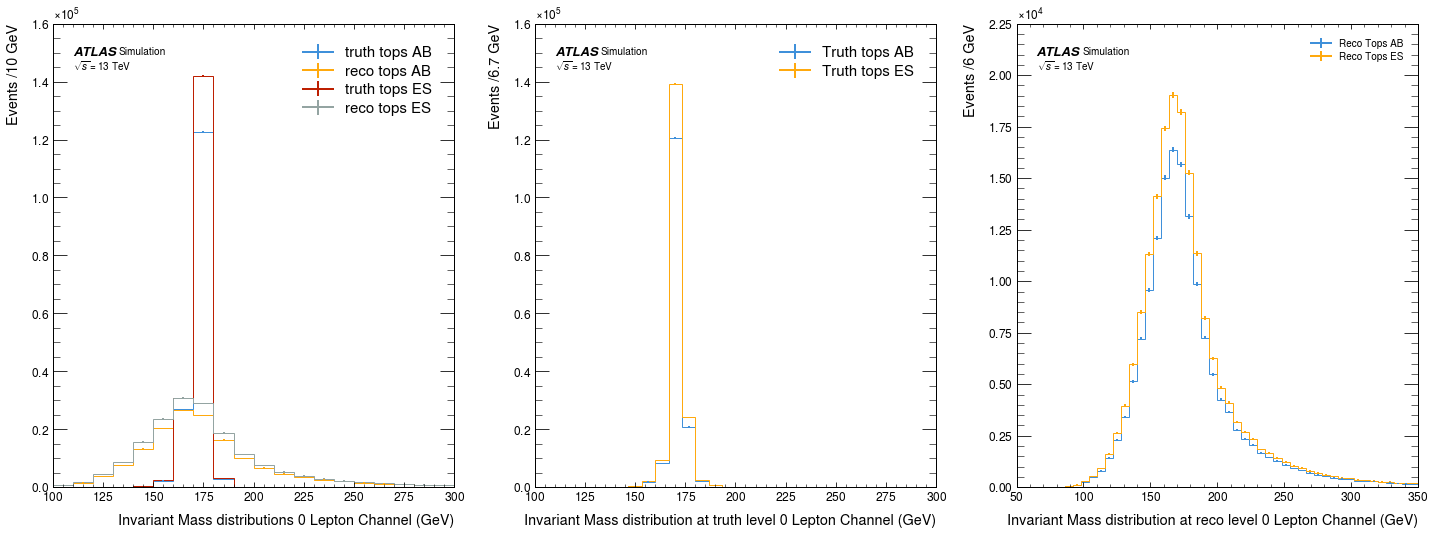

Peak bin center for truth tops: 170.50 GeV
Peak bin center for reco tops: 170.50 GeV
Peak bin center for Truth tops: 175.00 GeV
Peak bin center for Reco Tops: 171.50 GeV


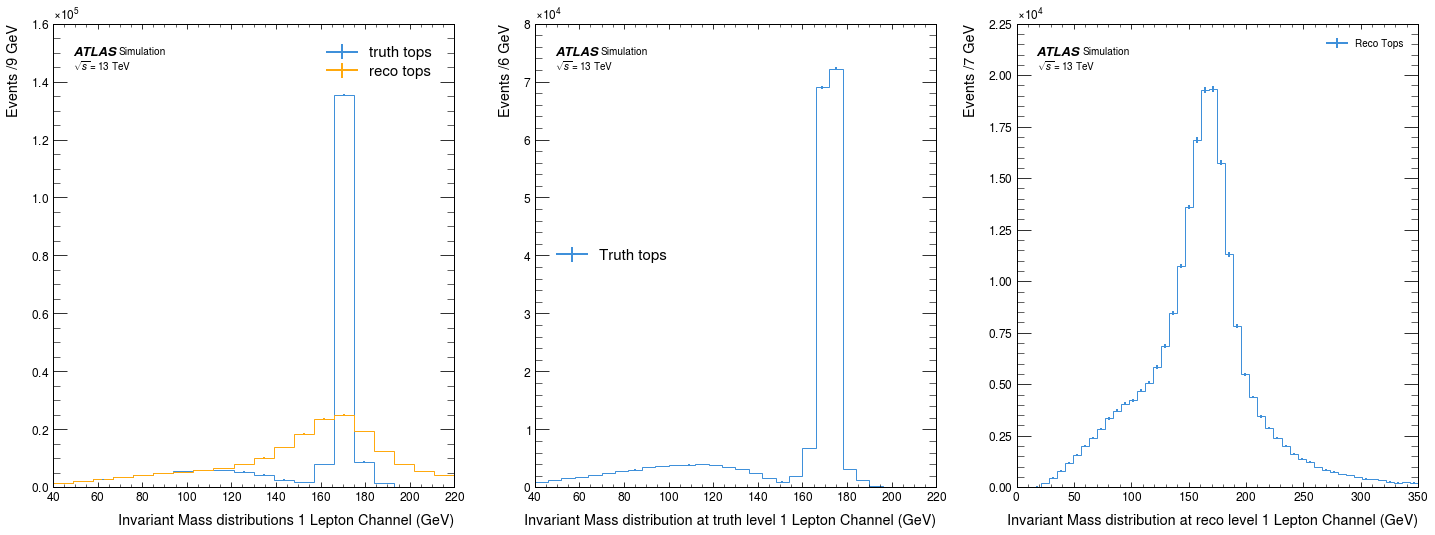

Peak bin center for truth tops AB: 170.50 GeV
Peak bin center for reco tops AB: 170.50 GeV
Peak bin center for Truth tops: 175.00 GeV
Peak bin center for Reco Tops: 164.50 GeV


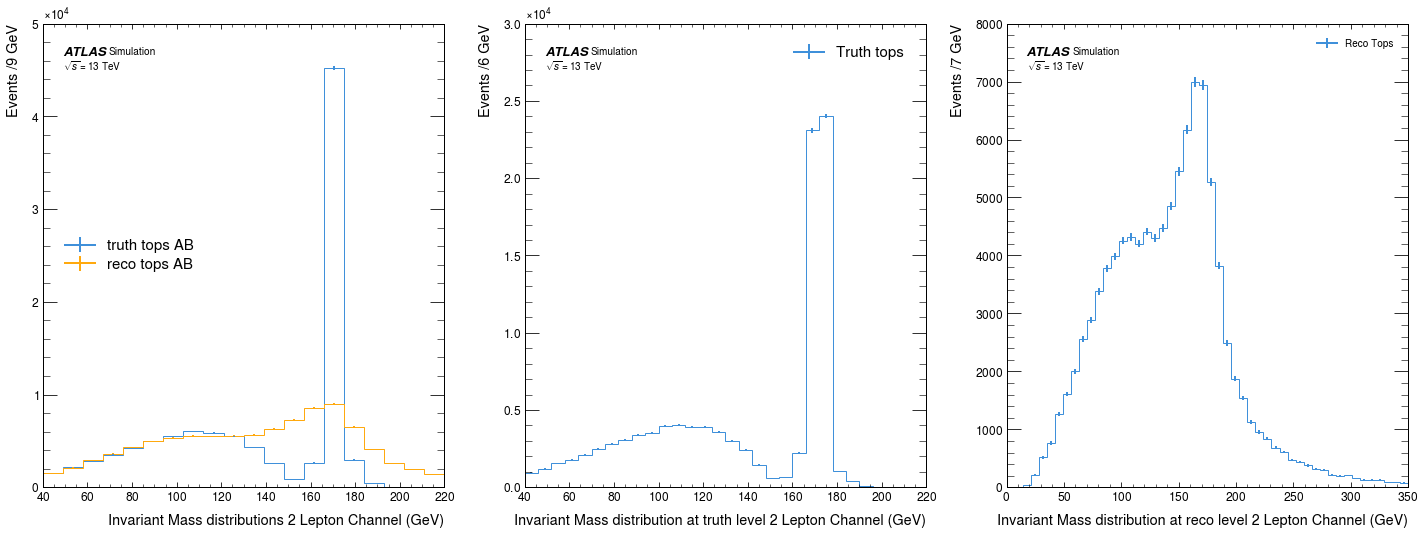

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([sm_truth_tops_4t_0L.m,sm_reco_tops_4t_0L.m, all_truth_tops_ES.m,ak.flatten(all_reco_tops_ES).m], 20, [r'truth tops AB', r'reco tops AB', r'truth tops ES', r'reco tops ES'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([sm_truth_tops_4t_0L.m,all_truth_tops_ES.m], 30, [r'Truth tops AB',r'Truth tops ES',r''], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([sm_reco_tops_4t_0L.m,ak.flatten(all_reco_tops_ES).m], 50, ['Reco Tops AB', 'Reco Tops ES'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([sm_truth_tops_4t_1L.m,sm_reco_tops_4t_1L.m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([sm_truth_tops_4t_1L.m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(40,220))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([sm_reco_tops_4t_1L.m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(0,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([sm_truth_tops_4t_2L.m,sm_reco_tops_4t_2L.m], 20, [r'truth tops AB', r'reco tops AB', r'truth tops ES', r'reco tops ES'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([sm_truth_tops_4t_2L.m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(40,220))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([sm_reco_tops_4t_2L.m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(0,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_4$: 171.25 GeV
Peak bin center for $t_1$: 163.75 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for $t_4$: 171.25 GeV
Peak bin center for Reco Tops: 171.25 GeV
Peak bin center for Truth Tops: 171.25 GeV


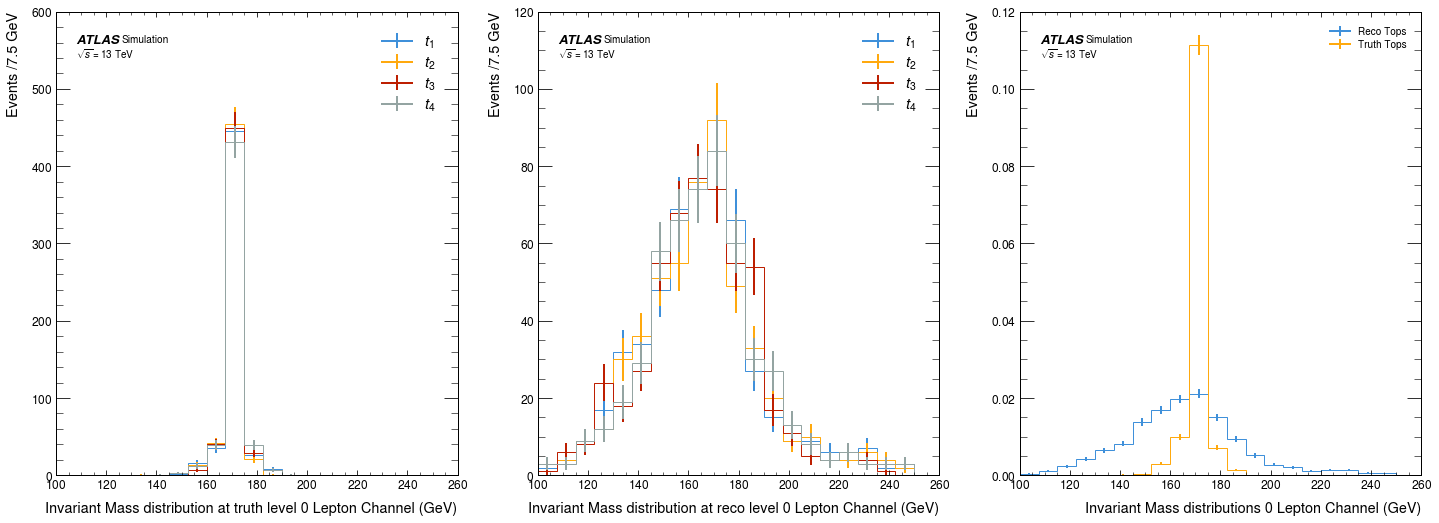

Peak bin center for lepton $t$: 116.50 GeV
Peak bin center for jet $t_1$: 170.50 GeV
Peak bin center for jet $t_2$: 170.50 GeV
Peak bin center for jet $t_3$: 170.50 GeV
Peak bin center for lepton $t$: 107.50 GeV
Peak bin center for jet $t_1$: 161.50 GeV
Peak bin center for jet $t_2$: 161.50 GeV
Peak bin center for jet $t_3$: 161.50 GeV
Peak bin center for Reco Tops: 161.50 GeV
Peak bin center for Truth Tops: 170.50 GeV


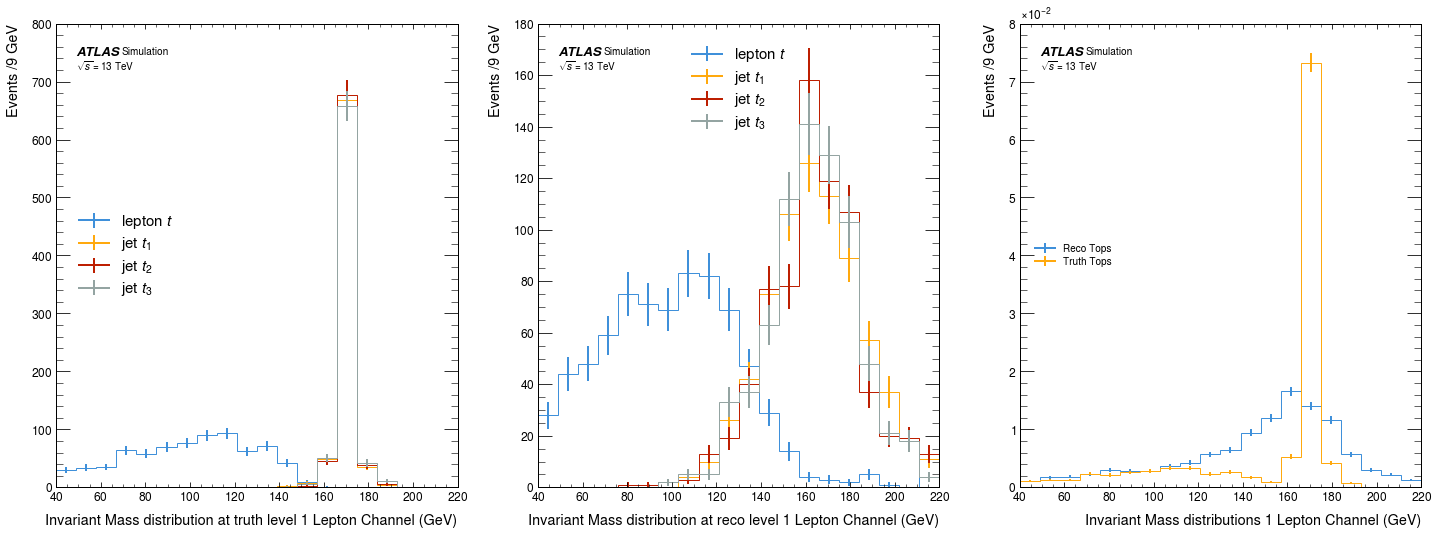

Peak bin center for jet $t_1$: 107.50 GeV
Peak bin center for jet $t_2$: 107.50 GeV
Peak bin center for lepton $t_1$: 170.50 GeV
Peak bin center for lepton $t_2$: 170.50 GeV
Peak bin center for jet $t_1$: 107.50 GeV
Peak bin center for jet $t_2$: 107.50 GeV
Peak bin center for lepton $t_1$: 161.50 GeV
Peak bin center for lepton $t_2$: 170.50 GeV
Peak bin center for Reco Tops: 161.50 GeV
Peak bin center for Truth Tops: 170.50 GeV


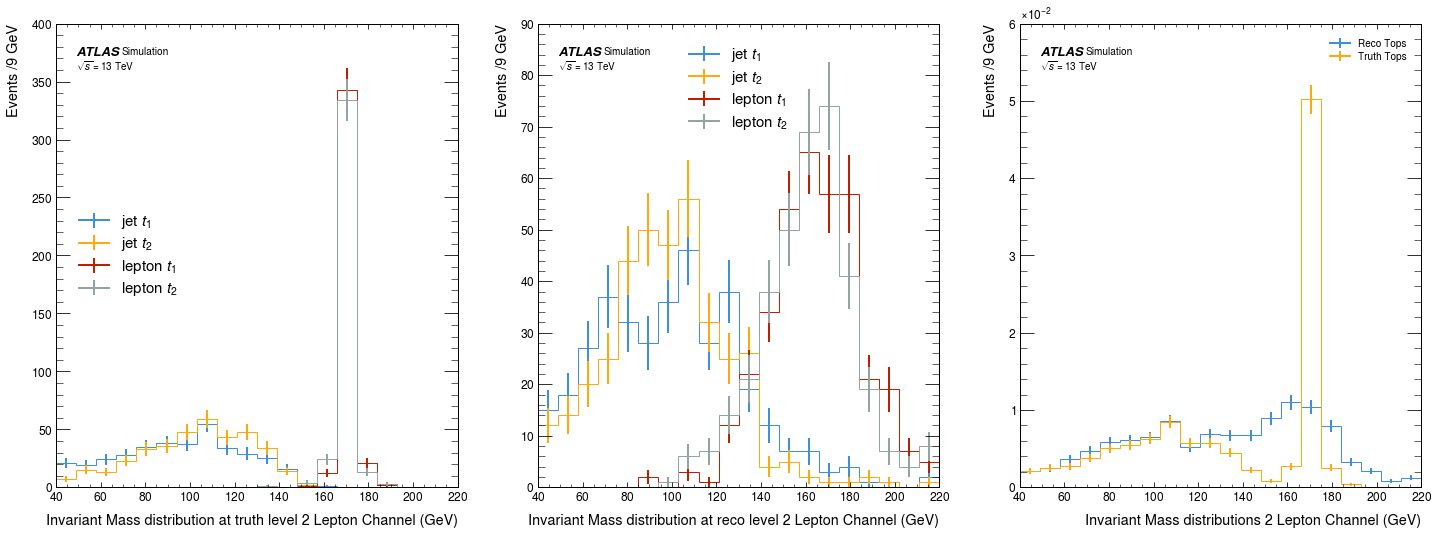

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_4t_0L[:,0].m, fm_truth_tops_4t_0L[:,1].m, fm_truth_tops_4t_0L[:,2].m, fm_truth_tops_4t_0L[:,3].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_tops_4t_0L[:,0].m, fm_reco_tops_4t_0L[:,1].m, fm_reco_tops_4t_0L[:,2].m, fm_reco_tops_4t_0L[:,3].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_0L.m,truth_tops_4t_0L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_4t_1L[:,0].m, fm_truth_tops_4t_1L[:,1].m, fm_truth_tops_4t_1L[:,2].m, fm_truth_tops_4t_1L[:,3].m], 20, [r'lepton $t$', r'jet $t_1$', r'jet $t_2$', r'jet $t_3$'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_tops_4t_1L[:,0].m, fm_reco_tops_4t_1L[:,1].m, fm_reco_tops_4t_1L[:,2].m, fm_reco_tops_4t_1L[:,3].m], 20, [r'lepton $t$', r'jet $t_1$', r'jet $t_2$', r'jet $t_3$'], ax[1], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_1L.m,truth_tops_4t_1L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(40,220))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_4t_2L[:,0].m, fm_truth_tops_4t_2L[:,1].m, fm_truth_tops_4t_2L[:,2].m, fm_truth_tops_4t_2L[:,3].m], 20, [r'jet $t_1$', r'jet $t_2$', r'lepton $t_1$', r'lepton $t_2$'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_tops_4t_2L[:,0].m, fm_reco_tops_4t_2L[:,1].m, fm_reco_tops_4t_2L[:,2].m, fm_reco_tops_4t_2L[:,3].m], 20, [r'jet $t_1$', r'jet $t_2$', r'lepton $t_1$', r'lepton $t_2$'], ax[1], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_2L.m,truth_tops_4t_2L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(40,220))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

### 3 Top Matching

In [32]:
tree3j = uproot.open(directory + "tttj_skimmed_nov14.root")
tree3j_truth = tree3j['Truth;1']
tree3j_reco = tree3j['Reco;1']

events_3tj_truth = tree3j_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tj_partonic = tree3j_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id',])
events_3tj_reco = tree3j_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt','mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tj_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tj_reco['el_pt'])
events_3tj_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tj_reco['mu_pt'])
events_3tj_reco['jet_e'] = np.sqrt(events_3tj_reco['jet_mass']**2+(events_3tj_reco['jet_pt']**2)*(np.cosh(events_3tj_reco['jet_eta']))**2)
events_3tj_reco['el_e'] = np.sqrt(events_3tj_reco['el_mass']**2+(events_3tj_reco['el_pt']**2)*(np.cosh(events_3tj_reco['el_eta']))**2)
events_3tj_reco['mu_e'] = np.sqrt(events_3tj_reco['mu_mass']**2+(events_3tj_reco['mu_pt']**2)*(np.cosh(events_3tj_reco['mu_eta']))**2)

good_events_3tj = ak.num(events_3tj_truth['b_id']) == 3

invalid_events_3tj_truth = events_3tj_truth[~good_events_3tj]
invalid_events_3tj_truth['b_id'], invalid_events_3tj_truth['b_pt'], invalid_events_3tj_truth['b_eta'] = invalid_events_3tj_truth['b_id'][:,1:], invalid_events_3tj_truth['b_pt'][:,1:], invalid_events_3tj_truth['b_eta'][:,1:]
invalid_events_3tj_truth['b_phi'], invalid_events_3tj_truth['b_e'], invalid_events_3tj_truth['b_mass'] = invalid_events_3tj_truth['b_phi'][:,1:], invalid_events_3tj_truth['b_e'][:,1:], invalid_events_3tj_truth['b_mass'][:,1:]

events_3tj_truth = ak.concatenate((events_3tj_truth[good_events_3tj], invalid_events_3tj_truth))
events_3tj_reco = ak.concatenate((events_3tj_reco[good_events_3tj], events_3tj_reco[~good_events_3tj]))
events_3tj_partonic = ak.concatenate((events_3tj_partonic[good_events_3tj], events_3tj_partonic[~good_events_3tj]))

x = events_3tj_truth['W_decay_id'][(events_3tj_truth['W_decay_id']==15)|(events_3tj_truth['W_decay_id']==-15)]
events_3tj_reco = events_3tj_reco[ak.num(x)==0]
events_3tj_partonic = events_3tj_partonic[ak.num(x)==0]
events_3tj_truth = events_3tj_truth[ak.num(x)==0]

neutrino_remover = (abs(events_3tj_truth['W_decay_id']) != 12)&(abs(events_3tj_truth['W_decay_id']) != 14)&(abs(events_3tj_truth['W_decay_id']) != 16)&(abs(events_3tj_truth['W_decay_id']) != 18)
events_3tj_truth['W_decay_id'] = events_3tj_truth['W_decay_id'][neutrino_remover]
events_3tj_truth['W_decay_pt'] = events_3tj_truth['W_decay_pt'][neutrino_remover]
events_3tj_truth['W_decay_eta'] = events_3tj_truth['W_decay_eta'][neutrino_remover]
events_3tj_truth['W_decay_phi'] = events_3tj_truth['W_decay_phi'][neutrino_remover]
events_3tj_truth['W_decay_e'] = events_3tj_truth['W_decay_e'][neutrino_remover]
events_3tj_truth['W_decay_mass'] = events_3tj_truth['W_decay_mass'][neutrino_remover]

jet_pt_3tj = events_3tj_reco['jet_pt'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_eta_3tj = events_3tj_reco['jet_eta'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_phi_3tj = events_3tj_reco['jet_phi'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_mass_3tj = events_3tj_reco['jet_mass'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_e_3tj = events_3tj_reco['jet_e'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]

electron_pt_3tj = events_3tj_reco['el_pt'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_eta_3tj = events_3tj_reco['el_eta'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_phi_3tj = events_3tj_reco['el_phi'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_mass_3tj = events_3tj_reco['el_mass'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_e_3tj = events_3tj_reco['el_e'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]

muon_pt_3tj = events_3tj_reco['mu_pt'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_eta_3tj = events_3tj_reco['mu_eta'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_phi_3tj = events_3tj_reco['mu_phi'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_mass_3tj = events_3tj_reco['mu_mass'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_e_3tj = events_3tj_reco['mu_e'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]


lepton_pt_3tj = ak.concatenate((muon_pt_3tj,electron_pt_3tj), axis=1)
lepton_eta_3tj = ak.concatenate((muon_eta_3tj,electron_eta_3tj), axis=1)
lepton_phi_3tj = ak.concatenate((muon_phi_3tj,electron_phi_3tj), axis=1)
lepton_mass_3tj = ak.concatenate((muon_mass_3tj,electron_mass_3tj), axis=1)
lepton_e_3tj = ak.concatenate((muon_e_3tj,electron_e_3tj), axis=1)

reco_pt_3tj = ak.concatenate((jet_pt_3tj,lepton_pt_3tj), axis=1)
reco_eta_3tj = ak.concatenate((jet_eta_3tj,lepton_eta_3tj), axis=1)
reco_phi_3tj = ak.concatenate((jet_phi_3tj,lepton_phi_3tj), axis=1)
reco_mass_3tj = ak.concatenate((jet_mass_3tj,lepton_mass_3tj), axis=1)
reco_e_3tj = ak.concatenate((jet_e_3tj,lepton_e_3tj), axis=1)

b_pt_3tj = events_3tj_truth['b_pt']
b_eta_3tj = events_3tj_truth['b_eta']
b_phi_3tj = events_3tj_truth['b_phi']
b_mass_3tj = events_3tj_truth['b_mass']
b_e_3tj = events_3tj_truth['b_e']
b_id_3tj = events_3tj_truth['b_id']

w_decay_pt_3tj = events_3tj_truth['W_decay_pt']
w_decay_eta_3tj = events_3tj_truth['W_decay_eta']
w_decay_phi_3tj = events_3tj_truth['W_decay_phi']
w_decay_mass_3tj = events_3tj_truth['W_decay_mass']
w_decay_e_3tj = events_3tj_truth['W_decay_e']
w_decay_id_3tj = events_3tj_truth['W_decay_id']

truth_pt_3tj = ak.concatenate((b_pt_3tj,w_decay_pt_3tj), axis=1)
truth_eta_3tj = ak.concatenate((b_eta_3tj,w_decay_eta_3tj), axis=1)
truth_phi_3tj = ak.concatenate((b_phi_3tj,w_decay_phi_3tj), axis=1)
truth_mass_3tj = ak.concatenate((b_mass_3tj,w_decay_mass_3tj), axis=1)
truth_e_3tj = ak.concatenate((b_e_3tj,w_decay_e_3tj), axis=1)
truth_id_3tj = ak.concatenate((b_id_3tj,w_decay_id_3tj), axis=1)

reco_3tj = vector.zip({'pt':reco_pt_3tj,'eta':reco_eta_3tj,'phi':reco_phi_3tj,'energy':reco_e_3tj})
truth_3tj = vector.zip({'pt':truth_pt_3tj,'eta':truth_eta_3tj,'phi':truth_phi_3tj,'energy':truth_e_3tj})

reco_3tj_leptons = vector.zip({'pt':lepton_pt_3tj,'eta':lepton_eta_3tj,'phi':lepton_phi_3tj,'energy':lepton_e_3tj})
reco_3tj_jets = vector.zip({'pt':jet_pt_3tj,'eta':jet_eta_3tj,'phi':jet_phi_3tj,'energy':jet_e_3tj})

truth_3tj = truth_3tj[(ak.num(reco_3tj)!=0)]
truth_id_3tj = truth_id_3tj[(ak.num(reco_3tj)!=0)]
events_3tj_truth = events_3tj_truth[(ak.num(reco_3tj)!=0)]
events_3tj_reco = events_3tj_reco[(ak.num(reco_3tj)!=0)]
reco_3tj_leptons = reco_3tj_leptons[(ak.num(reco_3tj)!=0)]
reco_3tj_jets = reco_3tj_jets[(ak.num(reco_3tj)!=0)]
reco_3tj = reco_3tj[(ak.num(reco_3tj)!=0)]

## Splitting into lepton channels

In [33]:
lepton_count_3tj = ak.num(events_3tj_truth['W_decay_id'][(abs(events_3tj_truth['W_decay_id'])>10)&(abs(events_3tj_truth['W_decay_id'])<19)])
events_3tj_truth_0L = events_3tj_truth[lepton_count_3tj == 0]
events_3tj_truth_1L = events_3tj_truth[lepton_count_3tj == 1]
events_3tj_truth_2L = events_3tj_truth[lepton_count_3tj == 2]
events_3tj_truth_3L = events_3tj_truth[lepton_count_3tj == 3]


truth_3tj_0L, truth_id_3tj_0L = truth_3tj[lepton_count_3tj == 0], truth_id_3tj[lepton_count_3tj == 0]
truth_3tj_1L, truth_id_3tj_1L = truth_3tj[lepton_count_3tj == 1], truth_id_3tj[lepton_count_3tj == 1]
truth_3tj_2L, truth_id_3tj_2L = truth_3tj[lepton_count_3tj == 2], truth_id_3tj[lepton_count_3tj == 2]
truth_3tj_3L, truth_id_3tj_3L = truth_3tj[lepton_count_3tj == 3], truth_id_3tj[lepton_count_3tj == 3]


reco_3tj_0L = reco_3tj[lepton_count_3tj == 0]
reco_3tj_1L = reco_3tj[lepton_count_3tj == 1]
reco_3tj_2L = reco_3tj[lepton_count_3tj == 2]
reco_3tj_3L = reco_3tj[lepton_count_3tj == 3]

reco_3tj_leptons_0L = reco_3tj_leptons[lepton_count_3tj == 0]
reco_3tj_leptons_1L = reco_3tj_leptons[lepton_count_3tj == 1]
reco_3tj_leptons_2L = reco_3tj_leptons[lepton_count_3tj == 2]
reco_3tj_leptons_3L = reco_3tj_leptons[lepton_count_3tj == 3]

reco_3tj_jets_0L = reco_3tj_jets[lepton_count_3tj == 0]
reco_3tj_jets_1L = reco_3tj_jets[lepton_count_3tj == 1]
reco_3tj_jets_2L = reco_3tj_jets[lepton_count_3tj == 2]
reco_3tj_jets_3L = reco_3tj_jets[lepton_count_3tj == 3]

In [37]:
matched_events_3tj_0L, _ = truth_matching(truth_3tj_0L, truth_id_3tj_0L, reco_3tj_jets_0L, reco_3tj_leptons_0L)

matched_3tj_0L = ak.zip({'reco': matched_events_3tj_0L['reco'], 'truth': matched_events_3tj_0L['truth']})

fm_truth_tops_3tj_0L, fm_reco_tops_3tj_0L = top_identifier(matched_3tj_0L, '3tj', 'fm', '0L')

dm_truth_tops_3tj_0L, dm_reco_tops_3tj_0L = top_identifier(matched_3tj_0L, '3tj', 'dm', '0L')

sm_truth_tops_3tj_0L, sm_reco_tops_3tj_0L = top_identifier(matched_3tj_0L, '3tj', 'sm', '0L', at_least=True)

reco_tops_3tj_0L = ak.concatenate((fm_reco_tops_3tj_0L[:,0], fm_reco_tops_3tj_0L[:,1], fm_reco_tops_3tj_0L[:,2]))
truth_tops_3tj_0L = ak.concatenate((fm_truth_tops_3tj_0L[:,0], fm_truth_tops_3tj_0L[:,1], fm_truth_tops_3tj_0L[:,2]))


matched_events_3tj_1L, no_dupes_bool_1L = truth_matching(truth_3tj_1L, truth_id_3tj_1L, reco_3tj_jets_1L, reco_3tj_leptons_1L)

no_dupes_events_3tj_1L = events_3tj_truth_1L[no_dupes_bool_1L]
lepton_indices_1L = ak.sort(ak.argsort(abs(no_dupes_events_3tj_1L['W_decay_id']), axis = 1, ascending=False)[:,:1], axis=1)

matched_3tj_1L = ak.zip({'reco': matched_events_3tj_1L['reco'], 'truth': matched_events_3tj_1L['truth']})

fm_truth_tops_3tj_1L, fm_reco_tops_3tj_1L = top_identifier(matched_3tj_1L, '3tj', 'fm', '1L',lepton_indices=lepton_indices_1L)
dm_truth_tops_3tj_1L, dm_reco_tops_3tj_1L = top_identifier(matched_3tj_1L, '3tj', 'dm', '1L',lepton_indices=lepton_indices_1L)
sm_truth_tops_3tj_1L, sm_reco_tops_3tj_1L = top_identifier(matched_3tj_1L, '3tj', 'sm', '1L',lepton_indices=lepton_indices_1L, at_least=True)

reco_tops_3tj_1L = ak.concatenate((fm_reco_tops_3tj_1L[:,0], fm_reco_tops_3tj_1L[:,1], fm_reco_tops_3tj_1L[:,2]))
truth_tops_3tj_1L = ak.concatenate((fm_truth_tops_3tj_1L[:,0], fm_truth_tops_3tj_1L[:,1], fm_truth_tops_3tj_1L[:,2]))


matched_events_3tj_2L, no_dupes_bool_2L = truth_matching(truth_3tj_2L, truth_id_3tj_2L, reco_3tj_jets_2L, reco_3tj_leptons_2L)

no_dupes_events_3tj_2L = events_3tj_truth_2L[no_dupes_bool_2L]
lepton_indices_2L = ak.sort(ak.argsort(abs(no_dupes_events_3tj_2L['W_decay_id']), axis = 1, ascending=False)[:,:2], axis=1)

matched_3tj_2L = ak.zip({'reco': matched_events_3tj_2L['reco'], 'truth': matched_events_3tj_2L['truth']})

fm_truth_tops_3tj_2L, fm_reco_tops_3tj_2L = top_identifier(matched_3tj_2L, '3tj', 'fm', '2L', lepton_indices=lepton_indices_2L)
dm_truth_tops_3tj_2L, dm_reco_tops_3tj_2L = top_identifier(matched_3tj_2L, '3tj', 'dm', '2L', lepton_indices=lepton_indices_2L)
sm_truth_tops_3tj_2L, sm_reco_tops_3tj_2L = top_identifier(matched_3tj_2L, '3tj', 'sm', '2L', lepton_indices=lepton_indices_2L, at_least=True)

reco_tops_3tj_2L = ak.concatenate((fm_reco_tops_3tj_2L[:,0], fm_reco_tops_3tj_2L[:,1], fm_reco_tops_3tj_2L[:,2]))
truth_tops_3tj_2L = ak.concatenate((fm_truth_tops_3tj_2L[:,0], fm_truth_tops_3tj_2L[:,1], fm_truth_tops_3tj_2L[:,2]))


9
starting dm
starting axis=0 concat
2079
8
starting dm
starting axis=0 concat
0
0
0
7
starting dm
starting axis=0 concat


Peak bin center for truth tops AB: 175.00 GeV
Peak bin center for reco tops AB: 165.00 GeV
Peak bin center for Truth tops AB: 170.00 GeV
Peak bin center for Reco Tops AB: 167.00 GeV


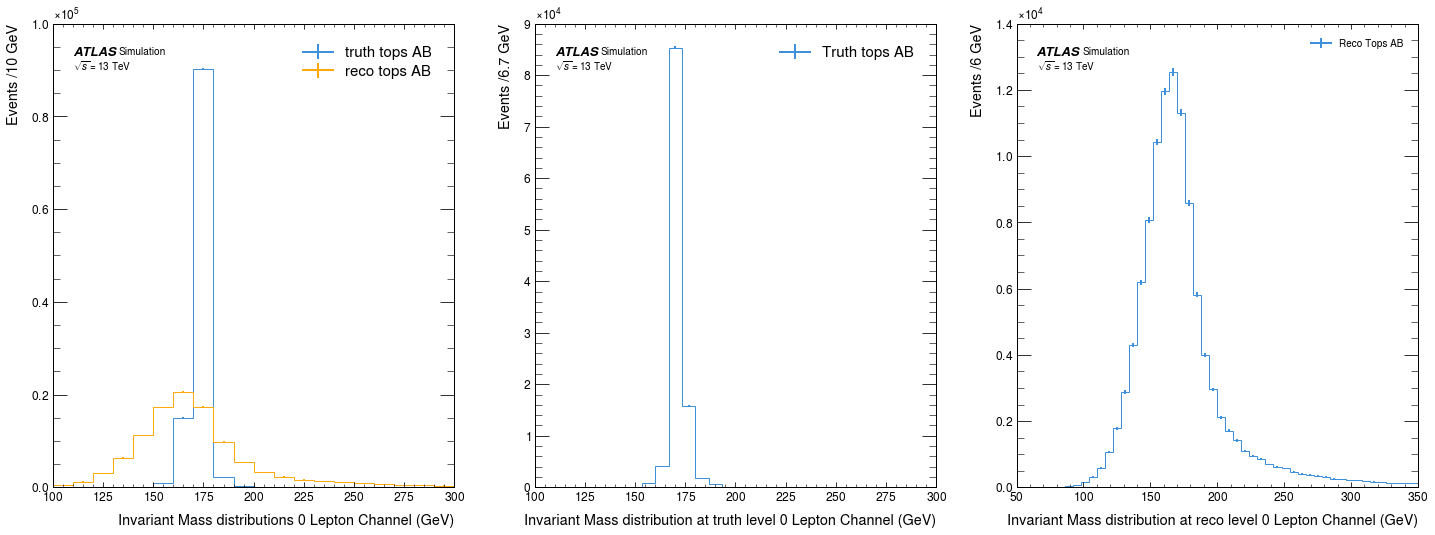

Peak bin center for truth tops: 170.50 GeV
Peak bin center for reco tops: 161.50 GeV
Peak bin center for Truth tops: 175.00 GeV
Peak bin center for Reco Tops: 164.50 GeV


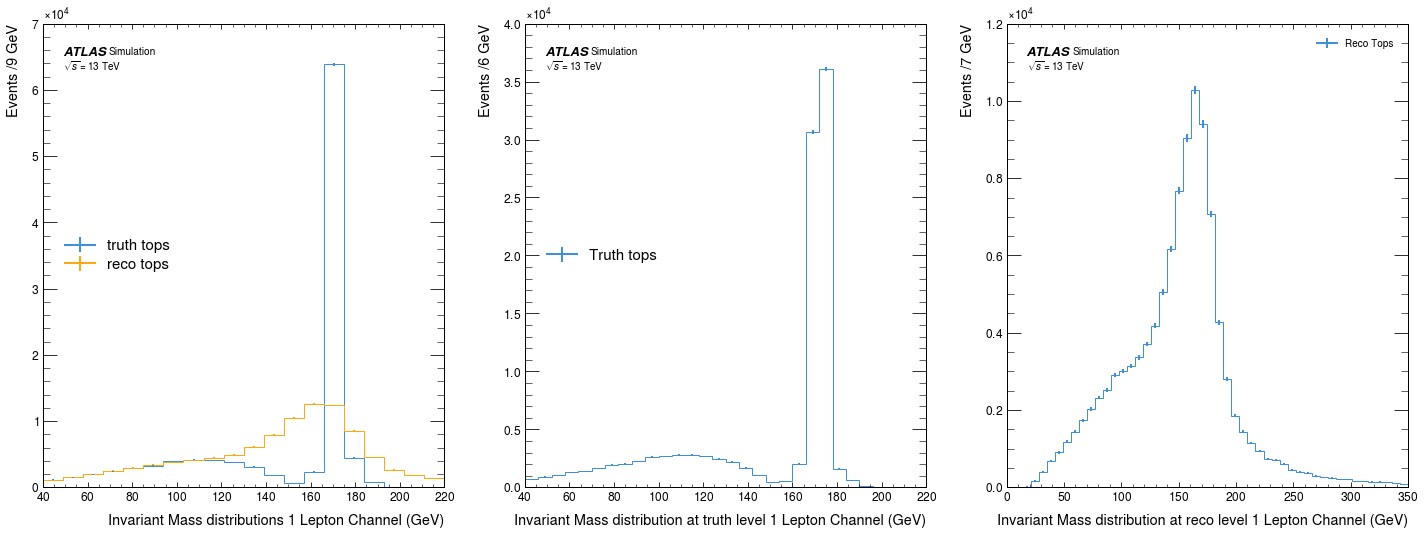

Peak bin center for truth tops AB: 170.50 GeV
Peak bin center for reco tops AB: 107.50 GeV
Peak bin center for Truth tops: 175.00 GeV
Peak bin center for Reco Tops: 108.50 GeV


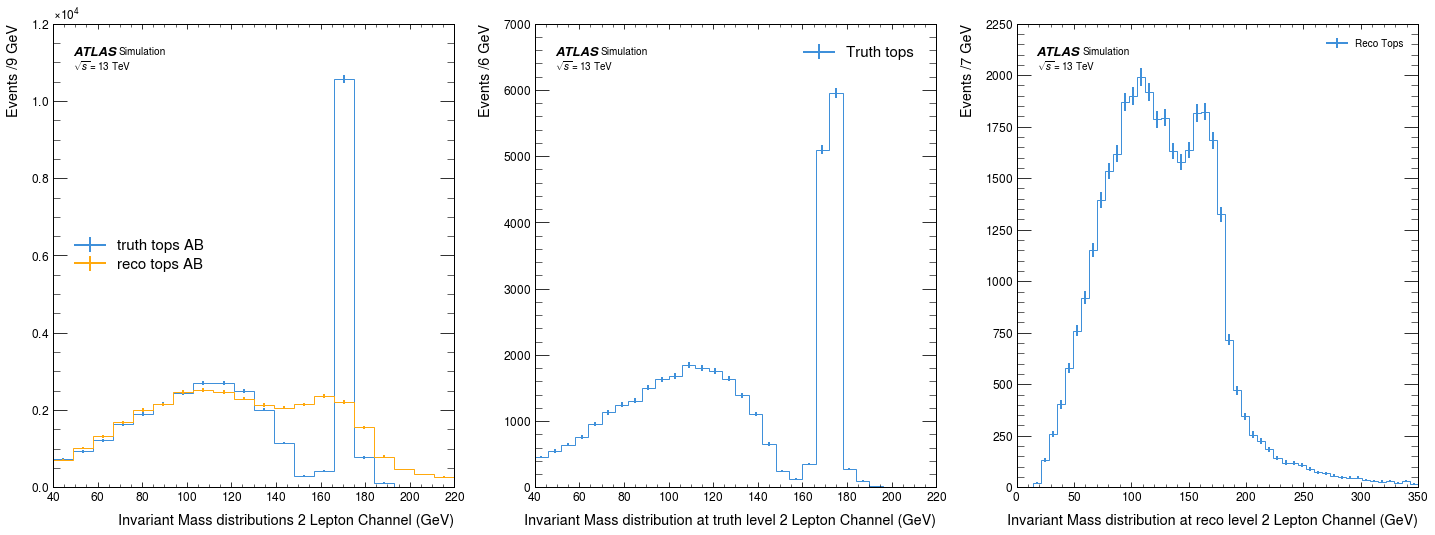

In [43]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([sm_truth_tops_3tj_0L.m,sm_reco_tops_3tj_0L.m], 20, [r'truth tops AB', r'reco tops AB', r'truth tops ES', r'reco tops ES'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([sm_truth_tops_3tj_0L.m], 30, [r'Truth tops AB',r'Truth tops ES',r''], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([sm_reco_tops_3tj_0L.m], 50, ['Reco Tops AB', 'Reco Tops ES'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([sm_truth_tops_3tj_1L.m,sm_reco_tops_3tj_1L.m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([sm_truth_tops_3tj_1L.m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(40,220))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([sm_reco_tops_3tj_1L.m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(0,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([sm_truth_tops_3tj_2L.m,sm_reco_tops_3tj_2L.m], 20, [r'truth tops AB', r'reco tops AB', r'truth tops ES', r'reco tops ES'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([sm_truth_tops_3tj_2L.m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(40,220))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([sm_reco_tops_3tj_2L.m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(0,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_1$: 163.75 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for Reco Tops: 163.75 GeV
Peak bin center for Truth Tops: 171.25 GeV


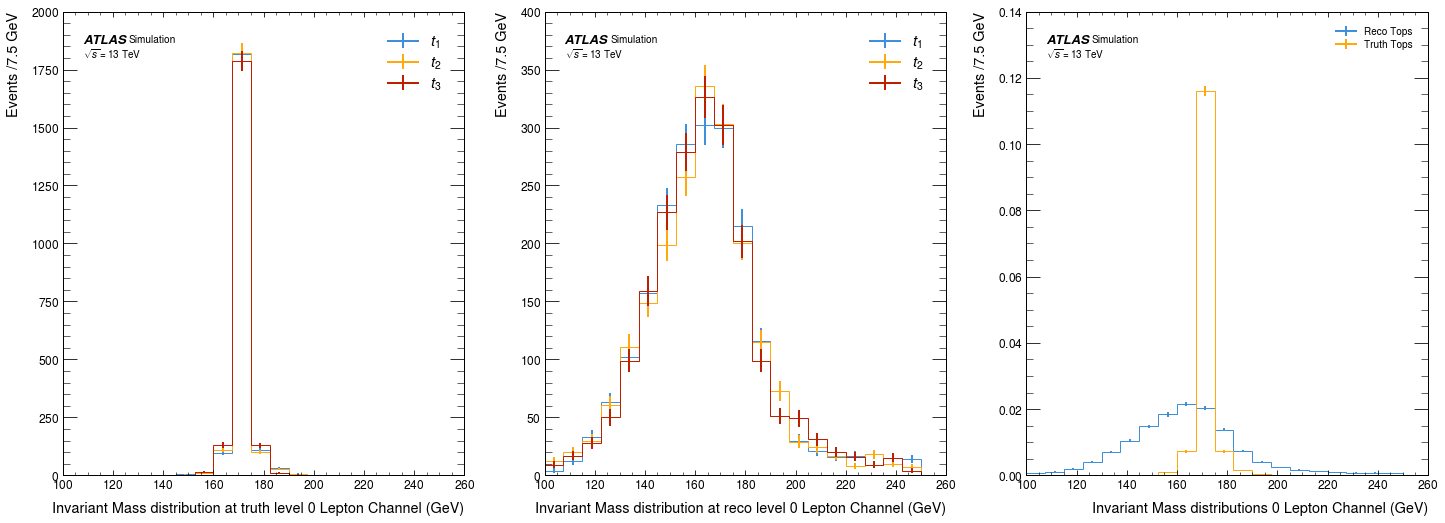

Peak bin center for lepton $t$: 107.50 GeV
Peak bin center for jet $t_1$: 170.50 GeV
Peak bin center for jet $t_2$: 170.50 GeV
Peak bin center for lepton $t$: 98.50 GeV
Peak bin center for jet $t_1$: 161.50 GeV
Peak bin center for jet $t_2$: 170.50 GeV
Peak bin center for Reco Tops: 161.50 GeV
Peak bin center for Truth Tops: 170.50 GeV


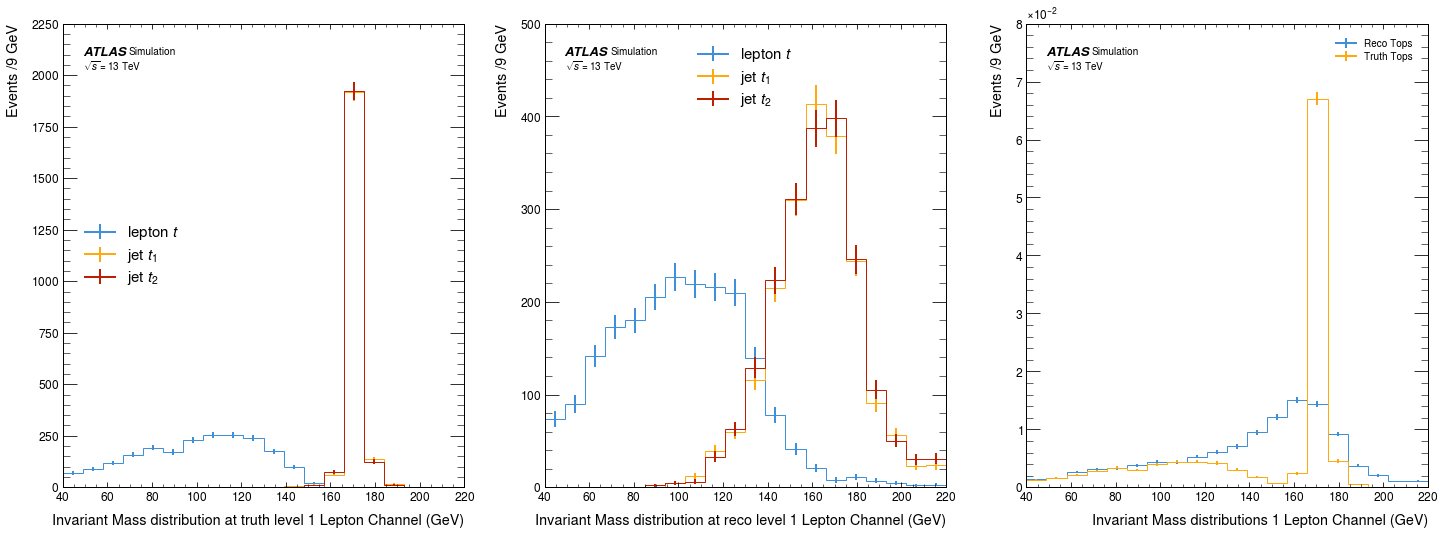

Peak bin center for jet $t_1$: 107.50 GeV
Peak bin center for jet $t_2$: 107.50 GeV
Peak bin center for lepton $t_1$: 170.50 GeV
Peak bin center for jet $t_1$: 98.50 GeV
Peak bin center for jet $t_2$: 98.50 GeV
Peak bin center for lepton $t_1$: 161.50 GeV
Peak bin center for Reco Tops: 98.50 GeV
Peak bin center for Truth Tops: 170.50 GeV


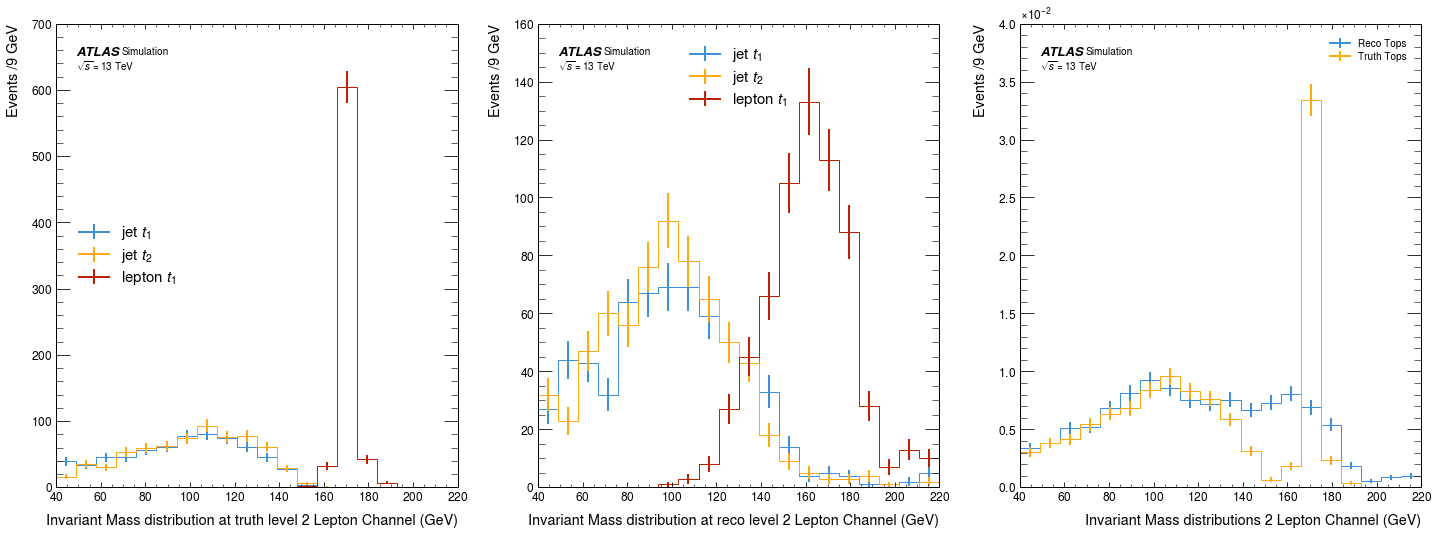

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tj_0L[:,0].m, fm_truth_tops_3tj_0L[:,1].m, fm_truth_tops_3tj_0L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_tops_3tj_0L[:,0].m, fm_reco_tops_3tj_0L[:,1].m, fm_reco_tops_3tj_0L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_3tj_0L.m,truth_tops_3tj_0L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tj_1L[:,0].m, fm_truth_tops_3tj_1L[:,1].m, fm_truth_tops_3tj_1L[:,2].m], 20, [r'lepton $t$', r'jet $t_1$', r'jet $t_2$', r'jet $t_3$'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_tops_3tj_1L[:,0].m, fm_reco_tops_3tj_1L[:,1].m, fm_reco_tops_3tj_1L[:,2].m], 20, [r'lepton $t$', r'jet $t_1$', r'jet $t_2$', r'jet $t_3$'], ax[1], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_3tj_1L.m,truth_tops_3tj_1L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(40,220))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tj_2L[:,0].m, fm_truth_tops_3tj_2L[:,1].m, fm_truth_tops_3tj_2L[:,2].m], 20, [r'jet $t_1$', r'jet $t_2$', r'lepton $t_1$', r'lepton $t_2$'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_tops_3tj_2L[:,0].m, fm_reco_tops_3tj_2L[:,1].m, fm_reco_tops_3tj_2L[:,2].m], 20, [r'jet $t_1$', r'jet $t_2$', r'lepton $t_1$', r'lepton $t_2$'], ax[1], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_3tj_2L.m,truth_tops_3tj_2L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(40,220))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

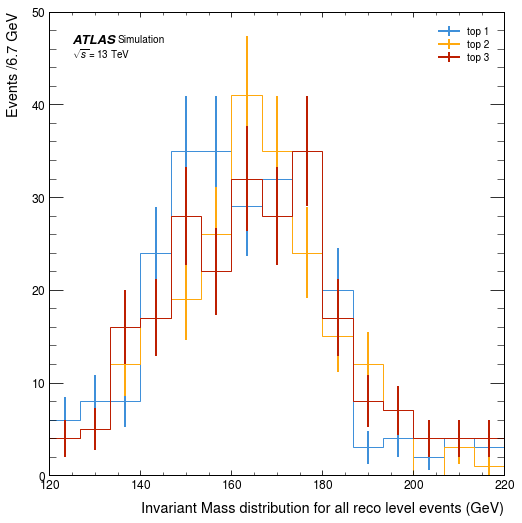

In [491]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([top_1_3tj.m, top_2_3tj.m, top_3_3tj.m], 15, ['top 1', 'top 2', 'top 3'], ax, density = False, x_units='GeV', set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution for all reco level events (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for Reco Tops: 167.50 GeV
Peak bin center for Truth Tops: 172.50 GeV


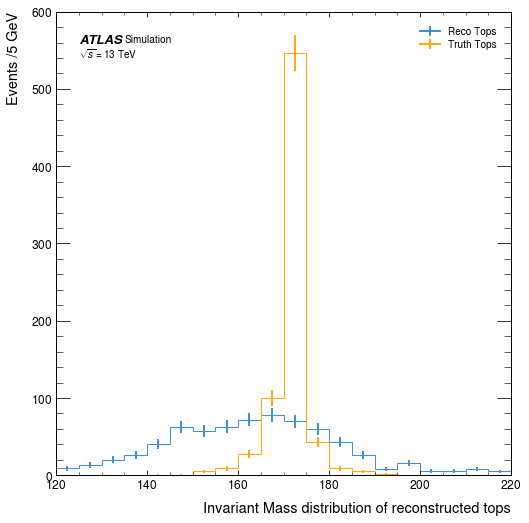

In [492]:
reco_tops_3tj = ak.concatenate((top_1_3tj, top_2_3tj, top_3_3tj))
truth_tops_3tj = ak.concatenate((t1, t2, t3))

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([reco_tops_3tj.m,truth_tops_3tj.m], 20, ['Reco Tops', 'Truth Tops'], ax, density = False, x_units='GeV', print_peak=True, set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution of reconstructed tops')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [ ]:
tree3W = uproot.open(directory + "tttW_withtruth_nov13.root")
tree3W_truth = tree3W['Truth;1']
tree3W_reco = tree3W['Reco;1']

events_3tW_truth = tree3W_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])

events_3tW_truth['b_id'][ak.num(events_3tW_truth['b_id'])!=3]

<Array [] type='0 * var * int32'>

In [47]:
tree3W = uproot.open(directory + "tttW_skimmed_nov14.root")
tree3W_truth = tree3W['Truth;1']
tree3W_reco = tree3W['Reco;1']

events_3tW_truth = tree3W_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tW_partonic = tree3W_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id',])
events_3tW_reco = tree3W_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt','mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tW_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tW_reco['el_pt'])
events_3tW_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tW_reco['mu_pt'])
events_3tW_reco['jet_e'] = np.sqrt(events_3tW_reco['jet_mass']**2+(events_3tW_reco['jet_pt']**2)*(np.cosh(events_3tW_reco['jet_eta']))**2)
events_3tW_reco['el_e'] = np.sqrt(events_3tW_reco['el_mass']**2+(events_3tW_reco['el_pt']**2)*(np.cosh(events_3tW_reco['el_eta']))**2)
events_3tW_reco['mu_e'] = np.sqrt(events_3tW_reco['mu_mass']**2+(events_3tW_reco['mu_pt']**2)*(np.cosh(events_3tW_reco['mu_eta']))**2)

good_events_3tW = ak.num(events_3tW_truth['b_id']) == 3

invalid_events_3tW_truth = events_3tW_truth[~good_events_3tW]
invalid_events_3tW_truth['b_id'], invalid_events_3tW_truth['b_pt'], invalid_events_3tW_truth['b_eta'] = invalid_events_3tW_truth['b_id'][:,1:], invalid_events_3tW_truth['b_pt'][:,1:], invalid_events_3tW_truth['b_eta'][:,1:]
invalid_events_3tW_truth['b_phi'], invalid_events_3tW_truth['b_e'], invalid_events_3tW_truth['b_mass'] = invalid_events_3tW_truth['b_phi'][:,1:], invalid_events_3tW_truth['b_e'][:,1:], invalid_events_3tW_truth['b_mass'][:,1:]

events_3tW_truth = ak.concatenate((events_3tW_truth[good_events_3tW], invalid_events_3tW_truth))
events_3tW_reco = ak.concatenate((events_3tW_reco[good_events_3tW], events_3tW_reco[~good_events_3tW]))
events_3tW_partonic = ak.concatenate((events_3tW_partonic[good_events_3tW], events_3tW_partonic[~good_events_3tW]))

x = events_3tW_truth['W_decay_id'][(events_3tW_truth['W_decay_id']==15)|(events_3tW_truth['W_decay_id']==-15)]
events_3tW_reco = events_3tW_reco[ak.num(x)==0]
events_3tW_partonic = events_3tW_partonic[ak.num(x)==0]
events_3tW_truth = events_3tW_truth[ak.num(x)==0]

neutrino_remover = (abs(events_3tW_truth['W_decay_id']) != 12)&(abs(events_3tW_truth['W_decay_id']) != 14)&(abs(events_3tW_truth['W_decay_id']) != 16)&(abs(events_3tW_truth['W_decay_id']) != 18)
events_3tW_truth['W_decay_id'] = events_3tW_truth['W_decay_id'][neutrino_remover]
events_3tW_truth['W_decay_pt'] = events_3tW_truth['W_decay_pt'][neutrino_remover]
events_3tW_truth['W_decay_eta'] = events_3tW_truth['W_decay_eta'][neutrino_remover]
events_3tW_truth['W_decay_phi'] = events_3tW_truth['W_decay_phi'][neutrino_remover]
events_3tW_truth['W_decay_e'] = events_3tW_truth['W_decay_e'][neutrino_remover]
events_3tW_truth['W_decay_mass'] = events_3tW_truth['W_decay_mass'][neutrino_remover]

jet_pt_3tW = events_3tW_reco['jet_pt'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_eta_3tW = events_3tW_reco['jet_eta'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_phi_3tW = events_3tW_reco['jet_phi'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_mass_3tW = events_3tW_reco['jet_mass'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_e_3tW = events_3tW_reco['jet_e'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]

electron_pt_3tW = events_3tW_reco['el_pt'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_eta_3tW = events_3tW_reco['el_eta'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_phi_3tW = events_3tW_reco['el_phi'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_mass_3tW = events_3tW_reco['el_mass'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_e_3tW = events_3tW_reco['el_e'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]

muon_pt_3tW = events_3tW_reco['mu_pt'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_eta_3tW = events_3tW_reco['mu_eta'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_phi_3tW = events_3tW_reco['mu_phi'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_mass_3tW = events_3tW_reco['mu_mass'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_e_3tW = events_3tW_reco['mu_e'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]


lepton_pt_3tW = ak.concatenate((muon_pt_3tW,electron_pt_3tW), axis=1)
lepton_eta_3tW = ak.concatenate((muon_eta_3tW,electron_eta_3tW), axis=1)
lepton_phi_3tW = ak.concatenate((muon_phi_3tW,electron_phi_3tW), axis=1)
lepton_mass_3tW = ak.concatenate((muon_mass_3tW,electron_mass_3tW), axis=1)
lepton_e_3tW = ak.concatenate((muon_e_3tW,electron_e_3tW), axis=1)

reco_pt_3tW = ak.concatenate((jet_pt_3tW,lepton_pt_3tW), axis=1)
reco_eta_3tW = ak.concatenate((jet_eta_3tW,lepton_eta_3tW), axis=1)
reco_phi_3tW = ak.concatenate((jet_phi_3tW,lepton_phi_3tW), axis=1)
reco_mass_3tW = ak.concatenate((jet_mass_3tW,lepton_mass_3tW), axis=1)
reco_e_3tW = ak.concatenate((jet_e_3tW,lepton_e_3tW), axis=1)

b_pt_3tW = events_3tW_truth['b_pt']
b_eta_3tW = events_3tW_truth['b_eta']
b_phi_3tW = events_3tW_truth['b_phi']
b_mass_3tW = events_3tW_truth['b_mass']
b_e_3tW = events_3tW_truth['b_e']
b_id_3tW = events_3tW_truth['b_id']

w_decay_pt_3tW = events_3tW_truth['W_decay_pt']
w_decay_eta_3tW = events_3tW_truth['W_decay_eta']
w_decay_phi_3tW = events_3tW_truth['W_decay_phi']
w_decay_mass_3tW = events_3tW_truth['W_decay_mass']
w_decay_e_3tW = events_3tW_truth['W_decay_e']
w_decay_id_3tW = events_3tW_truth['W_decay_id']

truth_pt_3tW = ak.concatenate((b_pt_3tW,w_decay_pt_3tW), axis=1)
truth_eta_3tW = ak.concatenate((b_eta_3tW,w_decay_eta_3tW), axis=1)
truth_phi_3tW = ak.concatenate((b_phi_3tW,w_decay_phi_3tW), axis=1)
truth_mass_3tW = ak.concatenate((b_mass_3tW,w_decay_mass_3tW), axis=1)
truth_e_3tW = ak.concatenate((b_e_3tW,w_decay_e_3tW), axis=1)
truth_id_3tW = ak.concatenate((b_id_3tW,w_decay_id_3tW), axis=1)

reco_3tW = vector.zip({'pt':reco_pt_3tW,'eta':reco_eta_3tW,'phi':reco_phi_3tW,'energy':reco_e_3tW})
truth_3tW = vector.zip({'pt':truth_pt_3tW,'eta':truth_eta_3tW,'phi':truth_phi_3tW,'energy':truth_e_3tW})

reco_3tW_leptons = vector.zip({'pt':lepton_pt_3tW,'eta':lepton_eta_3tW,'phi':lepton_phi_3tW,'energy':lepton_e_3tW})
reco_3tW_jets = vector.zip({'pt':jet_pt_3tW,'eta':jet_eta_3tW,'phi':jet_phi_3tW,'energy':jet_e_3tW})

truth_3tW = truth_3tW[(ak.num(reco_3tW)!=0)]
truth_id_3tW = truth_id_3tW[(ak.num(reco_3tW)!=0)]
events_3tW_truth = events_3tW_truth[(ak.num(reco_3tW)!=0)]
events_3tW_reco = events_3tW_reco[(ak.num(reco_3tW)!=0)]
reco_3tW_leptons = reco_3tW_leptons[(ak.num(reco_3tW)!=0)]
reco_3tW_jets = reco_3tW_jets[(ak.num(reco_3tW)!=0)]
reco_3tW = reco_3tW[(ak.num(reco_3tW)!=0)]

In [48]:
lepton_count_3tW = ak.num(events_3tW_truth['W_decay_id'][(abs(events_3tW_truth['W_decay_id'])>10)&(abs(events_3tW_truth['W_decay_id'])<19)])
events_3tW_truth_0L = events_3tW_truth[lepton_count_3tW == 0]
events_3tW_truth_1L = events_3tW_truth[lepton_count_3tW == 1]
events_3tW_truth_2L = events_3tW_truth[lepton_count_3tW == 2]
events_3tW_truth_3L = events_3tW_truth[lepton_count_3tW == 3]


truth_3tW_0L, truth_id_3tW_0L = truth_3tW[lepton_count_3tW == 0], truth_id_3tW[lepton_count_3tW == 0]
truth_3tW_1L, truth_id_3tW_1L = truth_3tW[lepton_count_3tW == 1], truth_id_3tW[lepton_count_3tW == 1]
truth_3tW_2L, truth_id_3tW_2L = truth_3tW[lepton_count_3tW == 2], truth_id_3tW[lepton_count_3tW == 2]
truth_3tW_3L, truth_id_3tW_3L = truth_3tW[lepton_count_3tW == 3], truth_id_3tW[lepton_count_3tW == 3]


reco_3tW_0L = reco_3tW[lepton_count_3tW == 0]
reco_3tW_1L = reco_3tW[lepton_count_3tW == 1]
reco_3tW_2L = reco_3tW[lepton_count_3tW == 2]
reco_3tW_3L = reco_3tW[lepton_count_3tW == 3]

reco_3tW_leptons_0L = reco_3tW_leptons[lepton_count_3tW == 0]
reco_3tW_leptons_1L = reco_3tW_leptons[lepton_count_3tW == 1]
reco_3tW_leptons_2L = reco_3tW_leptons[lepton_count_3tW == 2]
reco_3tW_leptons_3L = reco_3tW_leptons[lepton_count_3tW == 3]

reco_3tW_jets_0L = reco_3tW_jets[lepton_count_3tW == 0]
reco_3tW_jets_1L = reco_3tW_jets[lepton_count_3tW == 1]
reco_3tW_jets_2L = reco_3tW_jets[lepton_count_3tW == 2]
reco_3tW_jets_3L = reco_3tW_jets[lepton_count_3tW == 3]

In [49]:
matched_events_3tW_0L, _ = truth_matching(truth_3tW_0L, truth_id_3tW_0L, reco_3tW_jets_0L, reco_3tW_leptons_0L)

matched_3tW_0L = ak.zip({'reco': matched_events_3tW_0L['reco'], 'truth': matched_events_3tW_0L['truth']})

fm_truth_tops_3tW_0L, fm_reco_tops_3tW_0L = top_identifier(matched_3tW_0L, '3tW', 'fm', '0L')

dm_truth_tops_3tW_0L, dm_reco_tops_3tW_0L = top_identifier(matched_3tW_0L, '3tW', 'dm', '0L')

sm_truth_tops_3tW_0L, sm_reco_tops_3tW_0L = top_identifier(matched_3tW_0L, '3tW', 'sm', '0L', at_least=True)

reco_tops_3tW_0L = ak.concatenate((fm_reco_tops_3tW_0L[:,0], fm_reco_tops_3tW_0L[:,1], fm_reco_tops_3tW_0L[:,2]))
truth_tops_3tW_0L = ak.concatenate((fm_truth_tops_3tW_0L[:,0], fm_truth_tops_3tW_0L[:,1], fm_truth_tops_3tW_0L[:,2]))


matched_events_3tW_1L, no_dupes_bool_1L = truth_matching(truth_3tW_1L, truth_id_3tW_1L, reco_3tW_jets_1L, reco_3tW_leptons_1L)

no_dupes_events_3tW_1L = events_3tW_truth_1L[no_dupes_bool_1L]
lepton_indices_1L = ak.sort(ak.argsort(abs(no_dupes_events_3tW_1L['W_decay_id']), axis = 1, ascending=False)[:,:1], axis=1)

matched_3tW_1L = ak.zip({'reco': matched_events_3tW_1L['reco'], 'truth': matched_events_3tW_1L['truth']})

fm_truth_tops_3tW_1L, fm_reco_tops_3tW_1L = top_identifier(matched_3tW_1L, '3tW', 'fm', '1L',lepton_indices=lepton_indices_1L)
dm_truth_tops_3tW_1L, dm_reco_tops_3tW_1L = top_identifier(matched_3tW_1L, '3tW', 'dm', '1L',lepton_indices=lepton_indices_1L)
sm_truth_tops_3tW_1L, sm_reco_tops_3tW_1L = top_identifier(matched_3tW_1L, '3tW', 'sm', '1L',lepton_indices=lepton_indices_1L, at_least=True)

reco_tops_3tW_1L = ak.concatenate((fm_reco_tops_3tW_1L[:,0], fm_reco_tops_3tW_1L[:,1], fm_reco_tops_3tW_1L[:,2]))
truth_tops_3tW_1L = ak.concatenate((fm_truth_tops_3tW_1L[:,0], fm_truth_tops_3tW_1L[:,1], fm_truth_tops_3tW_1L[:,2]))


matched_events_3tW_2L, no_dupes_bool_2L = truth_matching(truth_3tW_2L, truth_id_3tW_2L, reco_3tW_jets_2L, reco_3tW_leptons_2L)

no_dupes_events_3tW_2L = events_3tW_truth_2L[no_dupes_bool_2L]
lepton_indices_2L = ak.sort(ak.argsort(abs(no_dupes_events_3tW_2L['W_decay_id']), axis = 1, ascending=False)[:,:2], axis=1)

matched_3tW_2L = ak.zip({'reco': matched_events_3tW_2L['reco'], 'truth': matched_events_3tW_2L['truth']})

fm_truth_tops_3tW_2L, fm_reco_tops_3tW_2L = top_identifier(matched_3tW_2L, '3tW', 'fm', '2L', lepton_indices=lepton_indices_2L)
dm_truth_tops_3tW_2L, dm_reco_tops_3tW_2L = top_identifier(matched_3tW_2L, '3tW', 'dm', '2L', lepton_indices=lepton_indices_2L)
sm_truth_tops_3tW_2L, sm_reco_tops_3tW_2L = top_identifier(matched_3tW_2L, '3tW', 'sm', '2L', lepton_indices=lepton_indices_2L, at_least=True)

reco_tops_3tW_2L = ak.concatenate((fm_reco_tops_3tW_2L[:,0], fm_reco_tops_3tW_2L[:,1], fm_reco_tops_3tW_2L[:,2]))
truth_tops_3tW_2L = ak.concatenate((fm_truth_tops_3tW_2L[:,0], fm_truth_tops_3tW_2L[:,1], fm_truth_tops_3tW_2L[:,2]))


11
starting dm
starting axis=0 concat
1568
10
starting dm
starting axis=0 concat
0
0
0
9
starting dm
starting axis=0 concat


Peak bin center for truth tops AB: 175.00 GeV
Peak bin center for reco tops AB: 165.00 GeV
Peak bin center for Truth tops AB: 170.00 GeV
Peak bin center for Reco Tops AB: 167.00 GeV


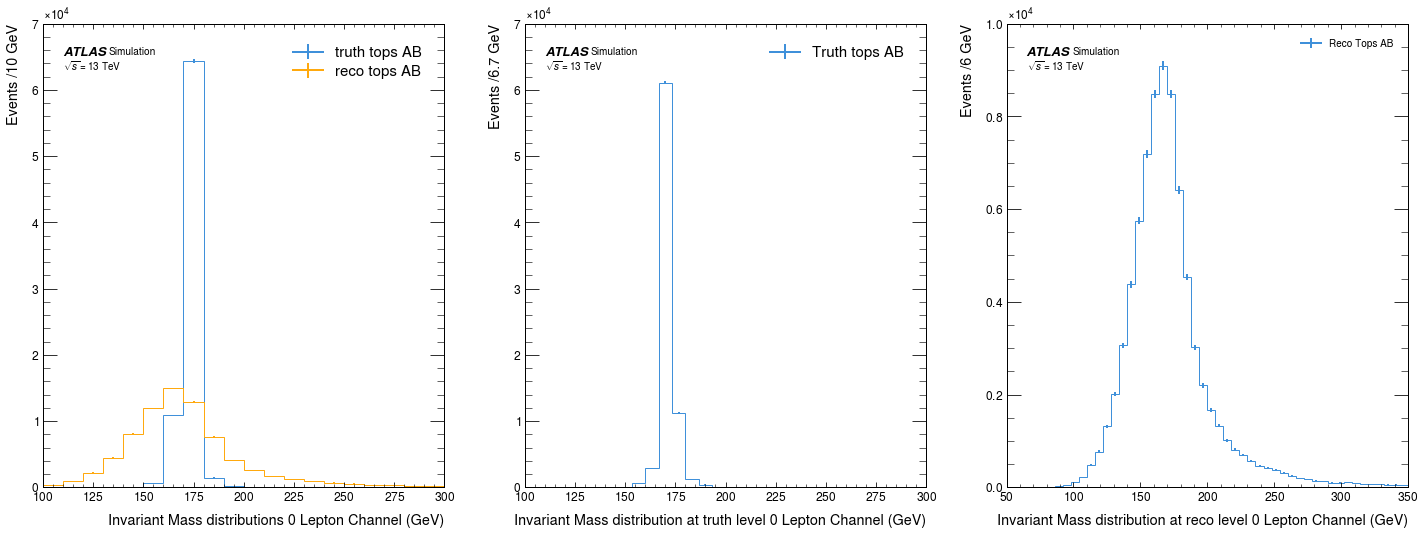

Peak bin center for truth tops: 170.50 GeV
Peak bin center for reco tops: 161.50 GeV
Peak bin center for Truth tops: 175.00 GeV
Peak bin center for Reco Tops: 164.50 GeV


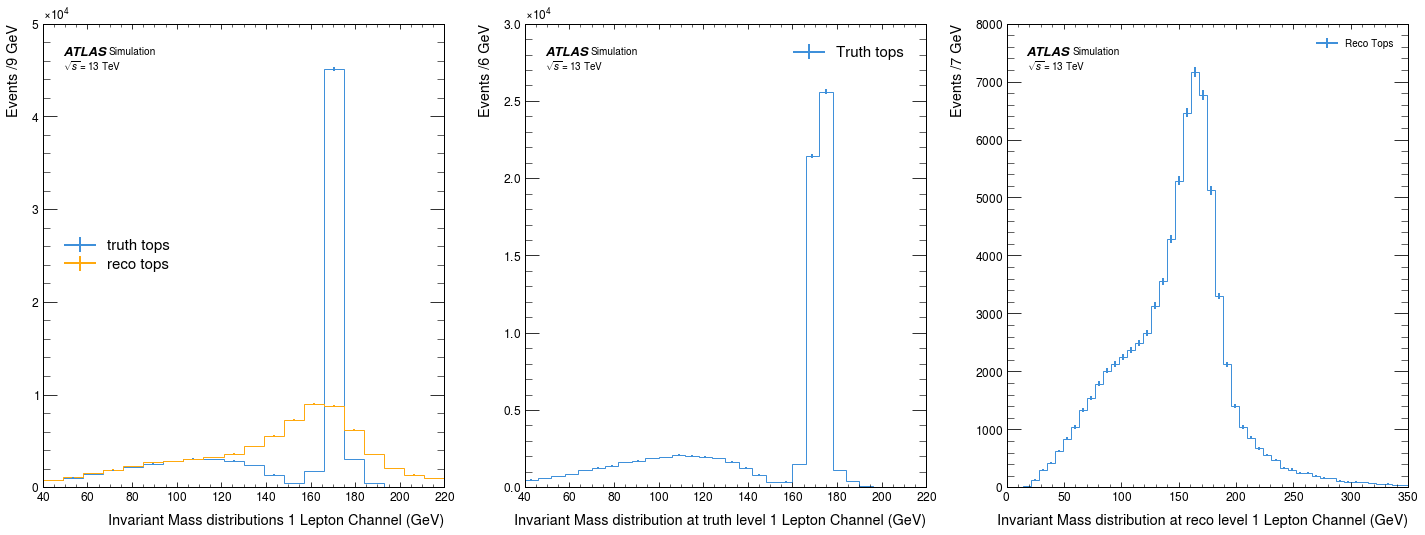

Peak bin center for truth tops AB: 170.50 GeV
Peak bin center for reco tops AB: 107.50 GeV
Peak bin center for Truth tops: 175.00 GeV
Peak bin center for Reco Tops: 101.50 GeV


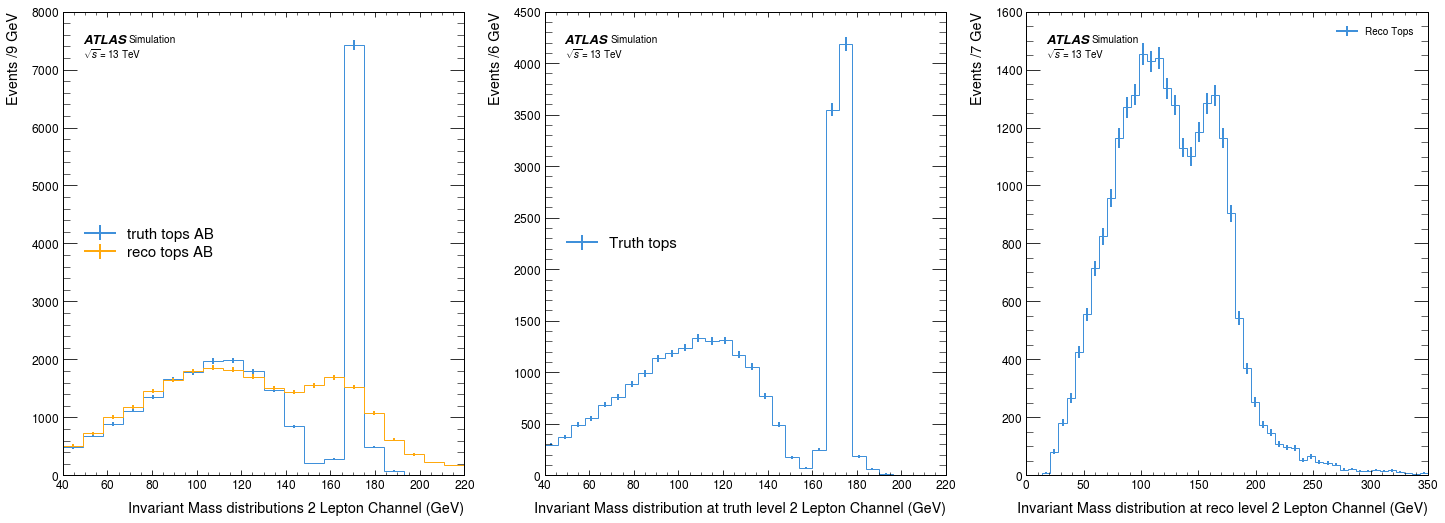

In [50]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([sm_truth_tops_3tW_0L.m,sm_reco_tops_3tW_0L.m], 20, [r'truth tops AB', r'reco tops AB', r'truth tops ES', r'reco tops ES'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([sm_truth_tops_3tW_0L.m], 30, [r'Truth tops AB',r'Truth tops ES',r''], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([sm_reco_tops_3tW_0L.m], 50, ['Reco Tops AB', 'Reco Tops ES'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([sm_truth_tops_3tW_1L.m,sm_reco_tops_3tW_1L.m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([sm_truth_tops_3tW_1L.m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(40,220))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([sm_reco_tops_3tW_1L.m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(0,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([sm_truth_tops_3tW_2L.m,sm_reco_tops_3tW_2L.m], 20, [r'truth tops AB', r'reco tops AB', r'truth tops ES', r'reco tops ES'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([sm_truth_tops_3tW_2L.m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(40,220))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([sm_reco_tops_3tW_2L.m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(0,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_1$: 163.75 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for Reco Tops: 171.25 GeV
Peak bin center for Truth Tops: 171.25 GeV


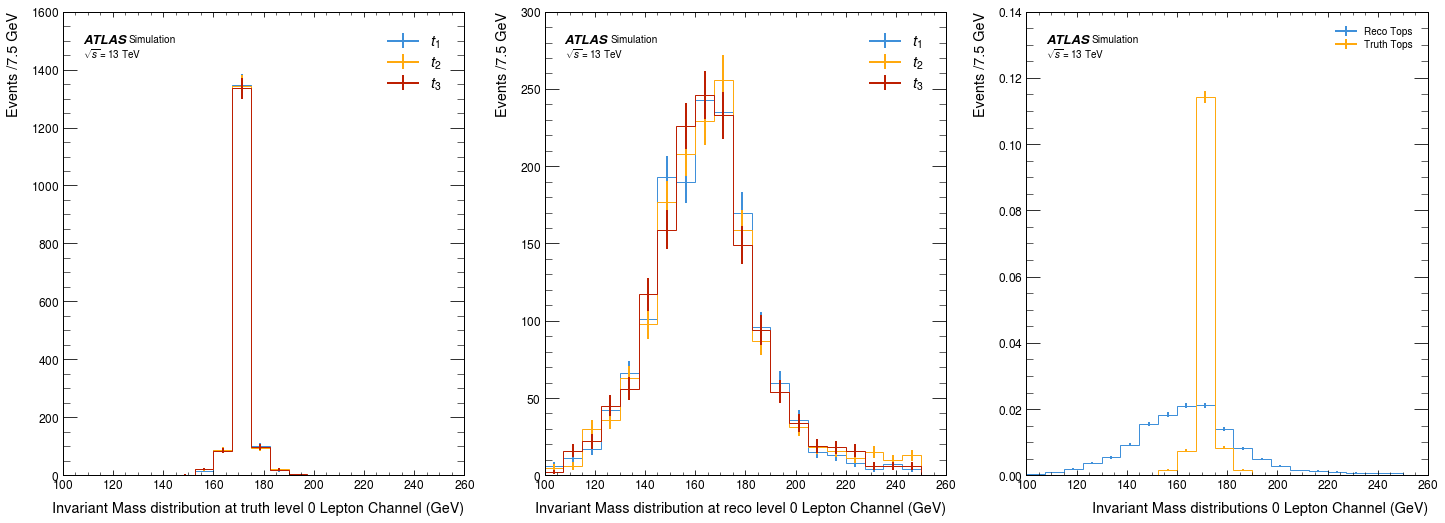

Peak bin center for lepton $t$: 107.50 GeV
Peak bin center for jet $t_1$: 170.50 GeV
Peak bin center for jet $t_2$: 170.50 GeV
Peak bin center for lepton $t$: 107.50 GeV
Peak bin center for jet $t_1$: 161.50 GeV
Peak bin center for jet $t_2$: 161.50 GeV
Peak bin center for Reco Tops: 161.50 GeV
Peak bin center for Truth Tops: 170.50 GeV


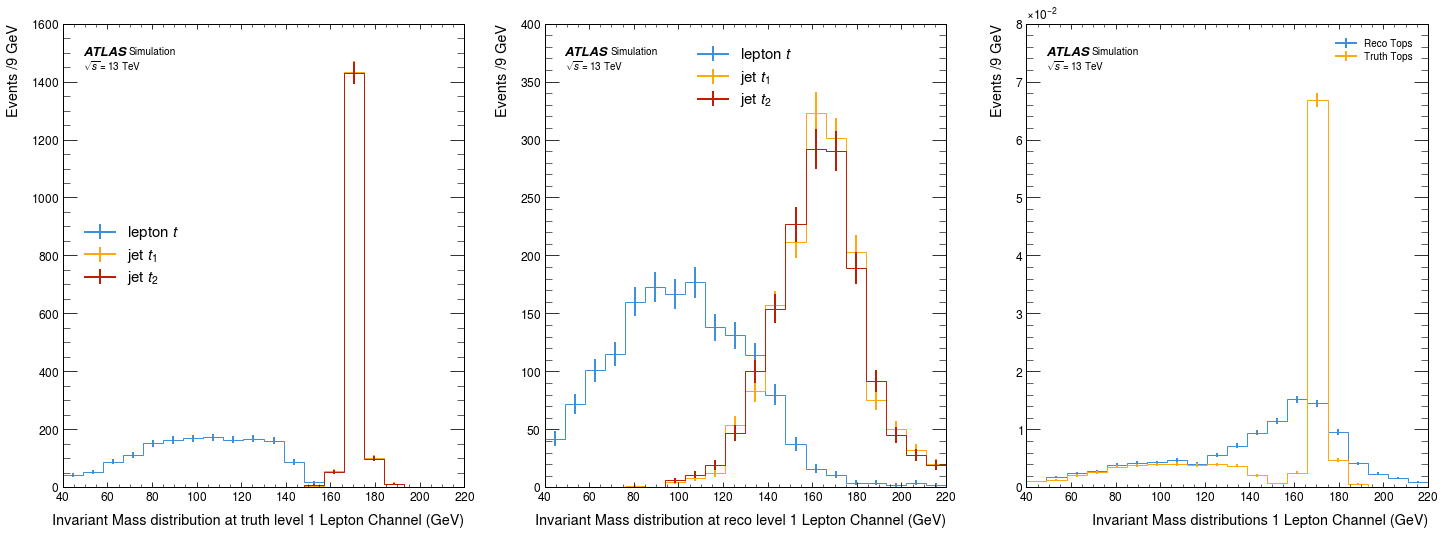

Peak bin center for jet $t_1$: 89.50 GeV
Peak bin center for jet $t_2$: 107.50 GeV
Peak bin center for lepton $t_1$: 170.50 GeV
Peak bin center for jet $t_1$: 98.50 GeV
Peak bin center for jet $t_2$: 107.50 GeV
Peak bin center for lepton $t_1$: 170.50 GeV
Peak bin center for Reco Tops: 134.50 GeV
Peak bin center for Truth Tops: 170.50 GeV


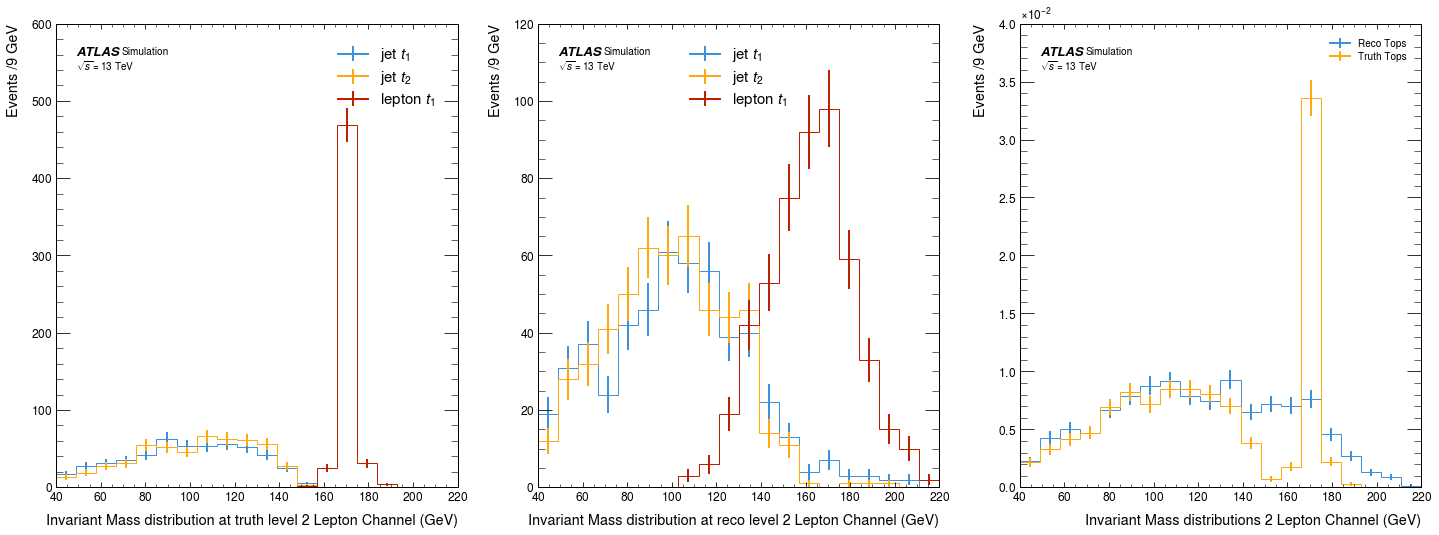

In [51]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tW_0L[:,0].m, fm_truth_tops_3tW_0L[:,1].m, fm_truth_tops_3tW_0L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_tops_3tW_0L[:,0].m, fm_reco_tops_3tW_0L[:,1].m, fm_reco_tops_3tW_0L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_3tW_0L.m,truth_tops_3tW_0L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tW_1L[:,0].m, fm_truth_tops_3tW_1L[:,1].m, fm_truth_tops_3tW_1L[:,2].m], 20, [r'lepton $t$', r'jet $t_1$', r'jet $t_2$', r'jet $t_3$'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_tops_3tW_1L[:,0].m, fm_reco_tops_3tW_1L[:,1].m, fm_reco_tops_3tW_1L[:,2].m], 20, [r'lepton $t$', r'jet $t_1$', r'jet $t_2$', r'jet $t_3$'], ax[1], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_3tW_1L.m,truth_tops_3tW_1L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(40,220))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tW_2L[:,0].m, fm_truth_tops_3tW_2L[:,1].m, fm_truth_tops_3tW_2L[:,2].m], 20, [r'jet $t_1$', r'jet $t_2$', r'lepton $t_1$', r'lepton $t_2$'], ax[0], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_tops_3tW_2L[:,0].m, fm_reco_tops_3tW_2L[:,1].m, fm_reco_tops_3tW_2L[:,2].m], 20, [r'jet $t_1$', r'jet $t_2$', r'lepton $t_1$', r'lepton $t_2$'], ax[1], density = False, x_units='GeV', set_range=(40,220), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_3tW_2L.m,truth_tops_3tW_2L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(40,220))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

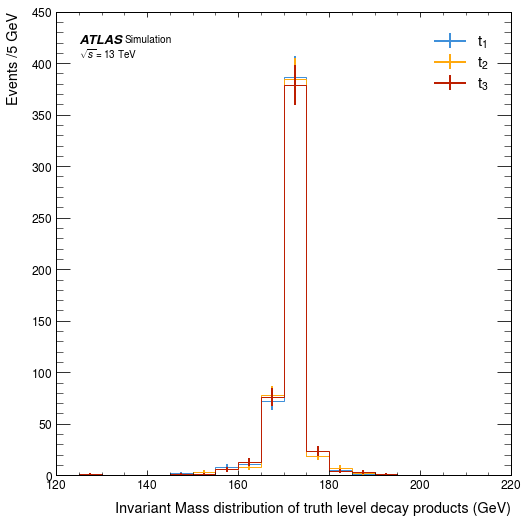

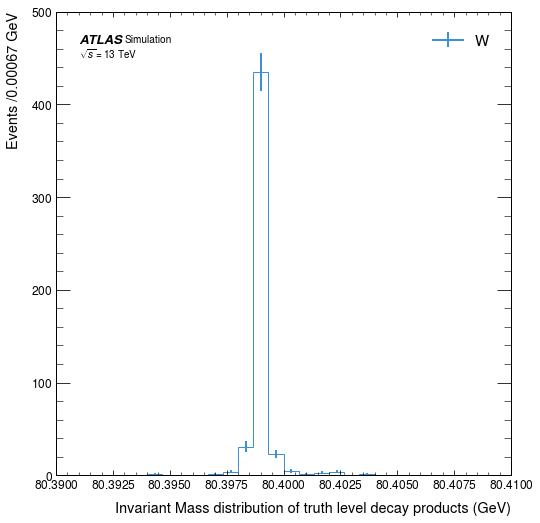

In [498]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([t1.m, t2.m, t3.m], 20, [r't$_1$', r't$_2$', r't$_3$'], ax, density = False, x_units='GeV', set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution of truth level decay products (GeV)')
ax.legend(fontsize=15)
plt.subplots_adjust(hspace=0.25)

plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([W.m], 30,[r'W'], ax, density = False, x_units='GeV', set_range=(80.39,80.41))
ax.set_xlabel(r'Invariant Mass distribution of truth level decay products (GeV)')
ax.legend(fontsize=15)
plt.subplots_adjust(hspace=0.25)

plt.show()

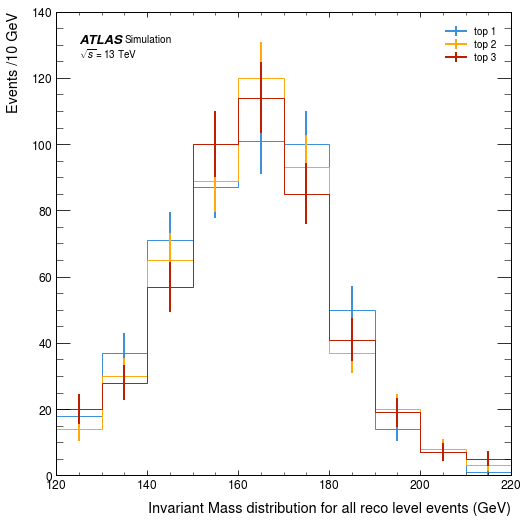

In [501]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([top_1_3tW.m, top_2_3tW.m, top_3_3tW.m], 10, ['top 1', 'top 2', 'top 3'], ax, density = False, x_units='GeV', set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution for all reco level events (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for Reco Tops: 162.50 GeV
Peak bin center for Truth Tops: 172.50 GeV


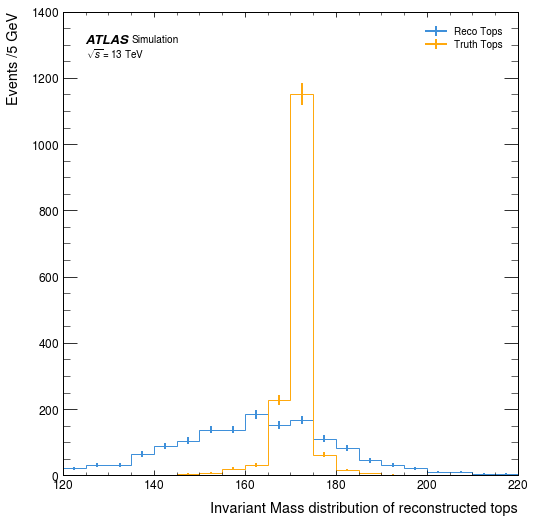

In [502]:
reco_tops_3tW = ak.concatenate((top_1_3tW, top_2_3tW, top_3_3tW))
truth_tops_3tW = ak.concatenate((t1, t2, t3))

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([reco_tops_3tW.m,truth_tops_3tW.m], 20, ['Reco Tops', 'Truth Tops'], ax, density = False, x_units='GeV', print_peak=True, set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution of reconstructed tops')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [504]:
tops_pt_4t = np.transpose(np.vstack(((top_1_4t_0L.pt,top_2_4t_0L.pt,antitop_1_4t_0L.pt,antitop_2_4t_0L.pt))))
tops_eta_4t = np.transpose(np.vstack(((top_1_4t_0L.eta,top_2_4t_0L.eta,antitop_1_4t_0L.eta,antitop_2_4t_0L.eta))))
tops_phi_4t = np.transpose(np.vstack(((top_1_4t_0L.phi,top_2_4t_0L.phi,antitop_1_4t_0L.phi,antitop_2_4t_0L.phi))))
tops_mass_4t = np.transpose(np.vstack(((top_1_4t_0L.m,top_2_4t_0L.m,antitop_1_4t_0L.m,antitop_2_4t_0L.m))))

top_1_3t = ak.concatenate((top_1_3tj,top_1_3tW))
top_2_3t = ak.concatenate((top_2_3tj,top_2_3tW))
top_3_3t = np.concatenate((top_3_3tj,top_3_3tW))

tops_pt_3t = np.transpose(np.vstack(((top_1_3t.pt,top_2_3t.pt,top_3_3t.pt))))
tops_eta_3t = np.transpose(np.vstack(((top_1_3t.eta,top_2_3t.eta,top_3_3t.eta))))
tops_phi_3t = np.transpose(np.vstack(((top_1_3t.phi,top_2_3t.phi,top_3_3t.phi))))
tops_mass_3t = np.transpose(np.vstack(((top_1_3t.m,top_2_3t.m,top_3_3t.m))))


tops_4t = vector.zip({'pt':tops_pt_4t,'eta':tops_eta_4t,'phi':tops_phi_4t, 'mass':tops_mass_4t})
tops_3t = vector.zip({'pt':tops_pt_3t,'eta':tops_eta_3t,'phi':tops_phi_3t, 'mass':tops_mass_3t})

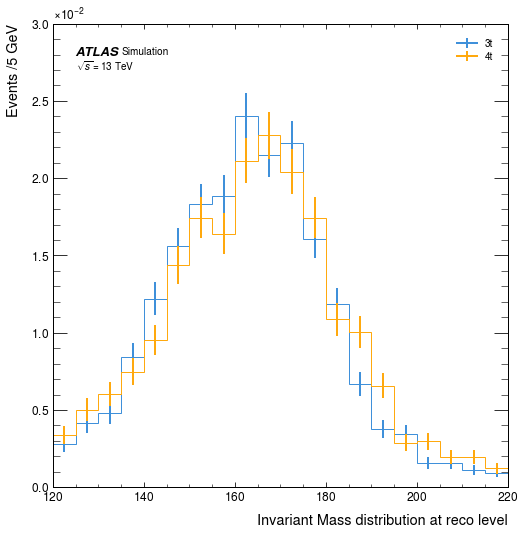

In [506]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([ak.flatten(tops_3t).m, ak.flatten(tops_4t).m], 20, ['3t', '4t'], ax, density = True, x_units='GeV', set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution at reco level')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [312]:
duos_4t = ak.combinations(tops_4t, 2, axis=1)
duos_3t = ak.combinations(tops_3t, 2, axis=1)

duo_masses_4t = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t = np.abs(np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1))

duo_masses_3t = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t = np.abs(np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1))

## Sorting

In [276]:
#pt
sorted_indices = np.argsort(tops_4t.rho)
trans_sorted_4t = tops_4t[sorted_indices]

highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.rho)
trans_sorted_3t = tops_3t[sorted_indices]

highest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#eta
sorted_indices = np.argsort(tops_4t.eta)
trans_sorted_4t = tops_4t[sorted_indices]

highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.eta)
trans_sorted_3t = tops_3t[sorted_indices]

highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.eta))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.eta))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#phi
sorted_indices = np.argsort(tops_4t.phi)
trans_sorted_4t = tops_4t[sorted_indices]

highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.phi)
trans_sorted_3t = tops_3t[sorted_indices]

highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.phi))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.phi))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#Energy
sorted_indices = np.argsort(np.sqrt((tops_4t.rho**2)*(np.cosh(tops_4t.eta)**2) + tops_4t.tau**2))
trans_sorted_4t = tops_4t[sorted_indices]

highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.sqrt((tops_3t.rho**2)*(np.cosh(tops_3t.eta)**2) + tops_3t.tau**2))
trans_sorted_3t = tops_3t[sorted_indices]

highest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

## Calculations

In [277]:
#deltaR
pt_deltaR_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
abs_eta_deltaR_4t = abs_highest_eta_4t.deltaR(abs_second_highest_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(third_highest_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_second_highest_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(second_highest_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_highest_eta_3t.deltaR(abs_middle_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

#deltaphi
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
low_delta_phi_4t = np.abs(third_highest_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(third_highest_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

#centrality
def centrality(particle, reference_1, reference_2):
    return np.abs(particle.rapidity - 0.5*(reference_1.rapidity + reference_2.rapidity))/np.abs(reference_1.rapidity-reference_2.rapidity)

centrality_1_3t = centrality(highest_pt_3t, middle_pt_3t, lowest_pt_3t)
centrality_2_3t = centrality(middle_pt_3t, highest_pt_3t, lowest_pt_3t)
centrality_3_3t = centrality(lowest_pt_3t, highest_pt_3t, middle_pt_3t)

centrality_1_4t = centrality(highest_pt_4t, second_highest_pt_4t, third_highest_pt_4t)
centrality_2_4t = centrality(second_highest_pt_4t, highest_pt_4t, third_highest_pt_4t)
centrality_3_4t = centrality(third_highest_pt_4t, highest_pt_4t, second_highest_pt_4t)

#Transverse Sphericity
sum_pt_3t = np.sum(tops_3t.pt, axis=1)
S_xy_3t = np.zeros((len(tops_3t),2,2))

S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)
transverse_sphericity_3t = 2*np.min(transverse_eigenvalues_3t, axis=1)/np.sum(transverse_eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)
S_xy_4t = np.zeros((len(tops_4t),2,2))

S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)
transverse_sphericity_4t = 2*np.min(transverse_eigenvalues_4t, axis=1)/np.sum(transverse_eigenvalues_4t, axis=1)

#Spericity
sum_p_3t = np.sum(tops_3t.p, axis=1)
S_xyz_3t = np.zeros((len(tops_3t),3,3))

S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)

S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)
sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)
S_xyz_4t = np.zeros((len(tops_4t),3,3))

S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)

S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)
sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

#Total invariant mass
total_4_4t = np.sum(tops_4t, axis=1)
total_4_3t = np.sum(tops_3t, axis=1)

/Users/archiebrooks/opt/anaconda3/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:249: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


In [278]:
print(np.shape(tops_4t))

[6034, 4]


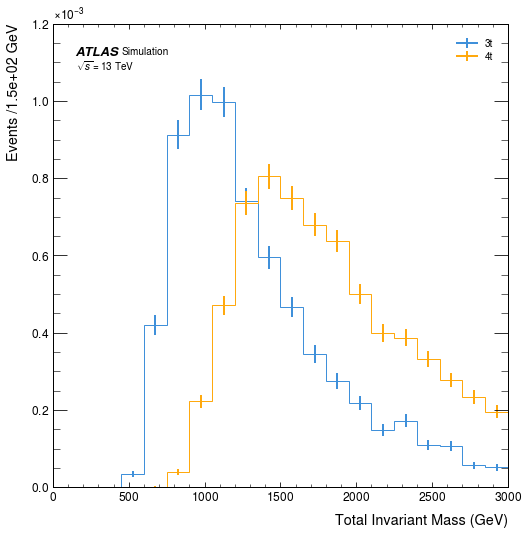

In [279]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([total_4_3t.m, total_4_4t.m], 20, ['3t', '4t'], ax, density = True, x_units='GeV', set_range=(0,3000))
ax.set_xlabel(r'Total Invariant Mass (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

## Plots

### Basic Kinematics

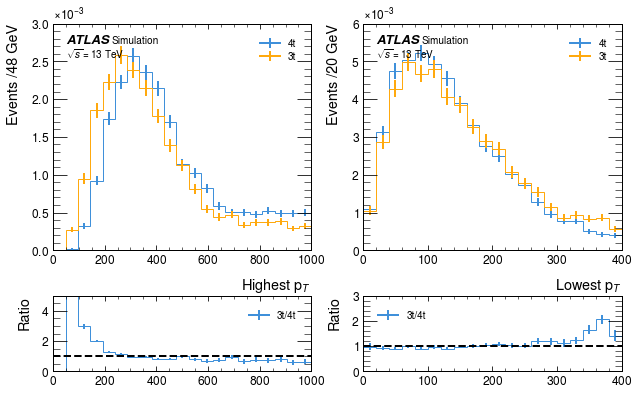

In [308]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_pt_4t.pt, highest_pt_3t.pt], 20, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(50,1000))
histogram([lowest_pt_4t.pt, lowest_pt_3t.pt], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,400))
ax[0,0].set_xlabel(r'Highest p$_T$')
ax[0,1].set_xlabel(r'Lowest p$_T$')
plt.subplots_adjust(hspace=0.3)
plt.show()

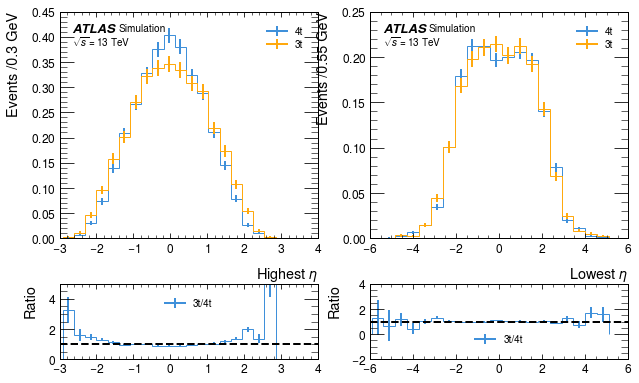

In [284]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_pt_4t.eta, highest_pt_3t.eta], 20, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0])
histogram([lowest_pt_4t.eta, lowest_pt_3t.eta], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1])
ax[0,0].set_xlabel(r'Highest $\eta$')
ax[0,1].set_xlabel(r'Lowest $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

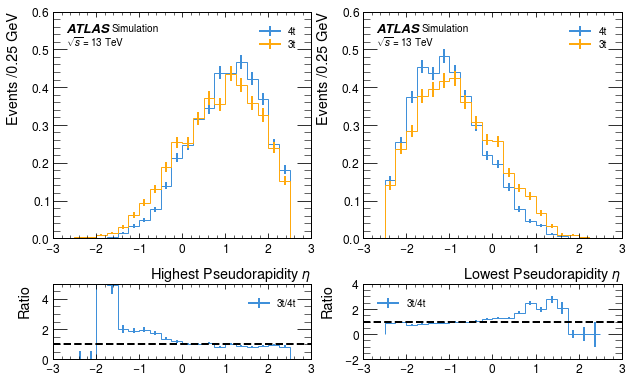

In [286]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_eta_4t.eta, highest_eta_3t.eta], 20, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(-2.5,2.5))
ax[0,0].set_xlabel(r'Highest Pseudorapidity $\eta$')
histogram([lowest_eta_4t.eta, lowest_eta_3t.eta], 20, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-2.5,2.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

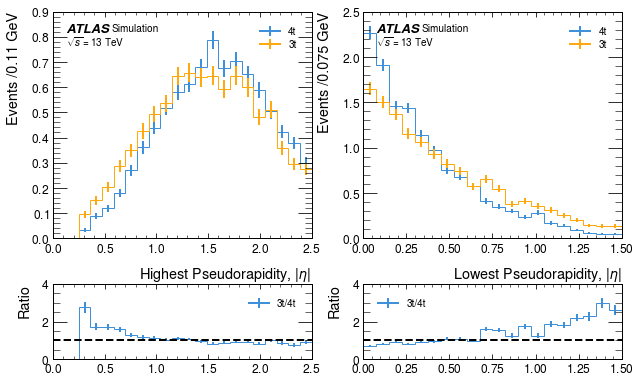

In [288]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_eta_4t.eta), np.abs(abs_highest_eta_3t.eta)], 20, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0.25,2.5))
ax[0,0].set_xlabel(r'Highest Pseudorapidity, $|\eta|$')
histogram([np.abs(abs_lowest_eta_4t.eta), np.abs(abs_lowest_eta_3t.eta)], 20, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,1.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity, $|\eta|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

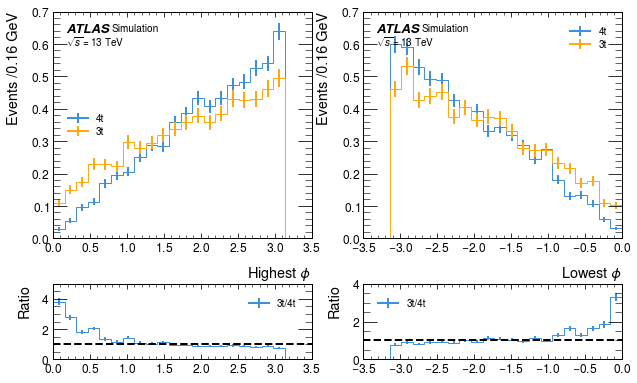

In [289]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_phi_4t.phi, highest_phi_3t.phi], 20, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,np.pi))
ax[0,0].set_xlabel(r'Highest $\phi$')
histogram([lowest_phi_4t.phi, lowest_phi_3t.phi], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-np.pi,0))
ax[0,1].set_xlabel(r'Lowest $\phi$')
plt.subplots_adjust(hspace=0.3)
plt.show()

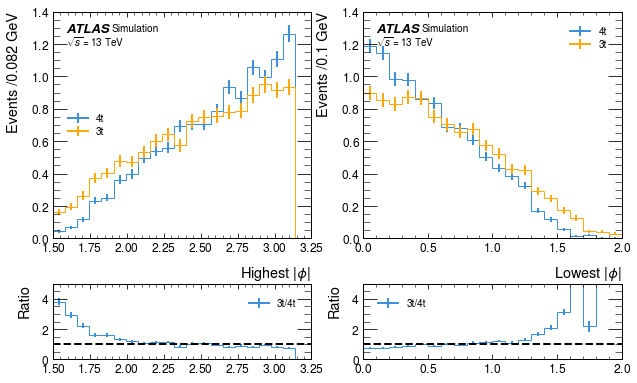

In [290]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_phi_4t.phi), np.abs(abs_highest_phi_3t.phi)], 20, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1.5,np.pi))
ax[0,0].set_xlabel(r'Highest $|\phi|$')
histogram([np.abs(abs_lowest_phi_4t.phi), np.abs(abs_lowest_phi_3t.phi)], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,2))
ax[0,1].set_xlabel(r'Lowest $|\phi|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

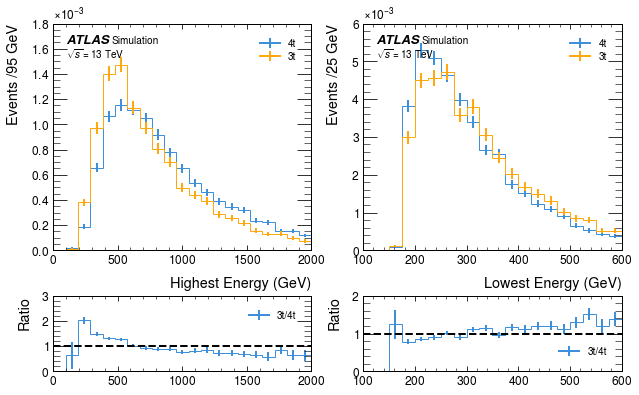

In [291]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_e_4t.E, highest_e_3t.E], 20, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(100,2000))
ax[0,0].set_xlabel(r'Highest Energy (GeV)')
histogram([lowest_e_4t.E, lowest_e_3t.E], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(100,600))
ax[0,1].set_xlabel(r'Lowest Energy (GeV)')
plt.subplots_adjust(hspace=0.3)
plt.show()

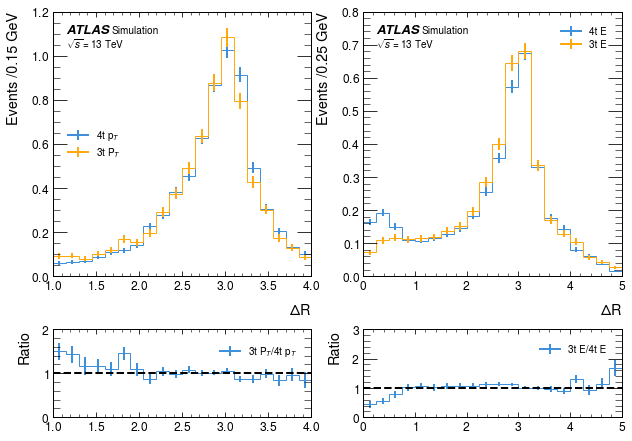

In [292]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([pt_deltaR_4t, pt_deltaR_3t], 20, [r'4t p$_T$', r'3t P$_T$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([e_deltaR_4t, e_deltaR_3t], 20, [r'4t E', r'3t E'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

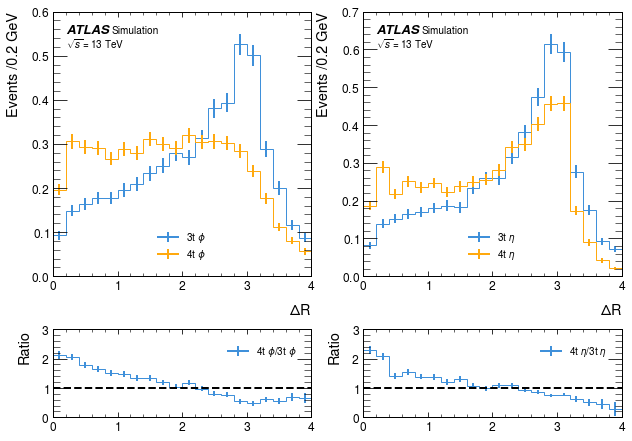

In [293]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([phi_deltaR_3t, phi_deltaR_4t], 20, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([eta_deltaR_3t, eta_deltaR_4t], 20, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

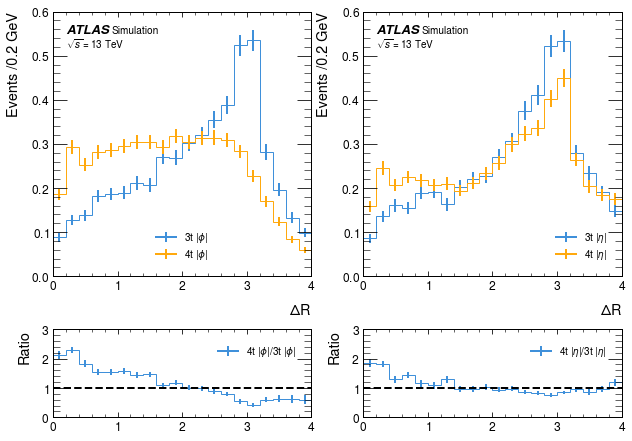

In [294]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([abs_phi_deltaR_3t, abs_phi_deltaR_4t], 20, [r'3t $|\phi|$', r'4t $|\phi|$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([abs_eta_deltaR_3t, abs_eta_deltaR_4t], 20, [r'3t $|\eta|$', r'4t $|\eta|$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

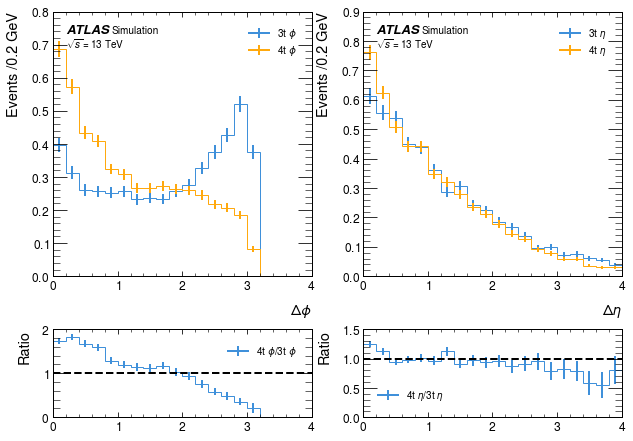

In [295]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([high_delta_phi_3t, high_delta_phi_4t], 20, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([high_delta_eta_3t, high_delta_eta_4t], 20, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

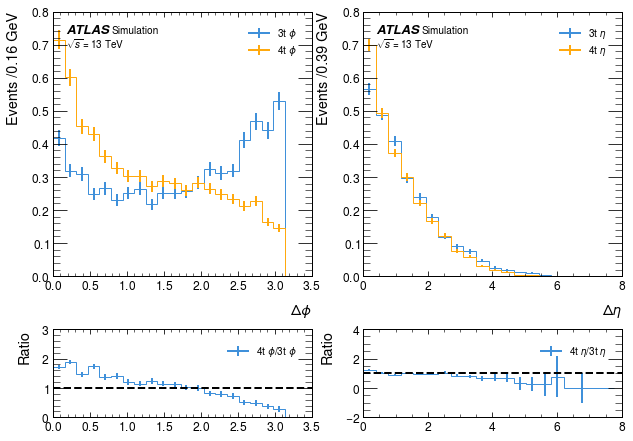

In [296]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([low_delta_phi_3t, low_delta_phi_4t], 20, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0])
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([low_delta_eta_3t, low_delta_eta_4t], 20, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1])
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

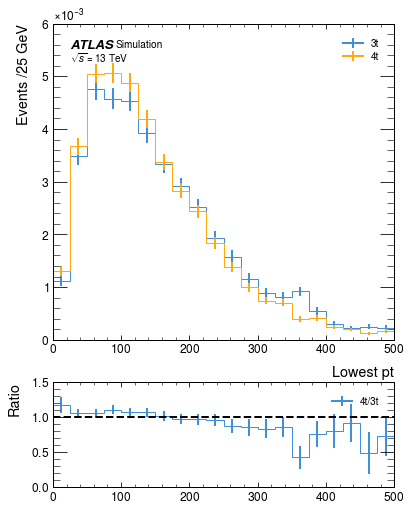

In [298]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([lowest_pt_3t.rho, lowest_pt_4t.rho], 20, ['3t', '4t'], ax[0],density=True, ratio=True, ratio_axes=ax[1], set_range=(0,500))
ax[0].set_xlabel('Lowest pt')
plt.show()

### High Level Partonic Analysis

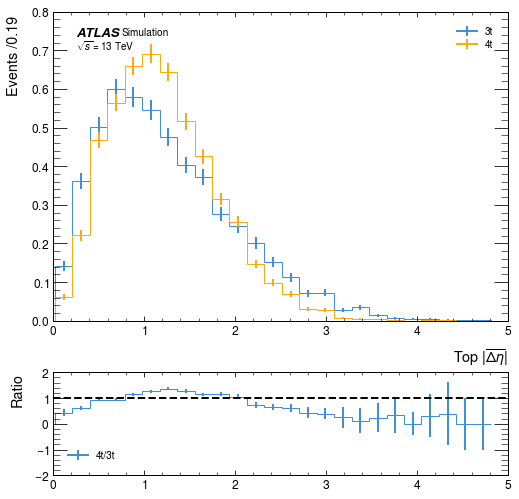

In [299]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaeta_3t,deltaeta_4t], 25, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $|\overline{\Delta\eta}|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

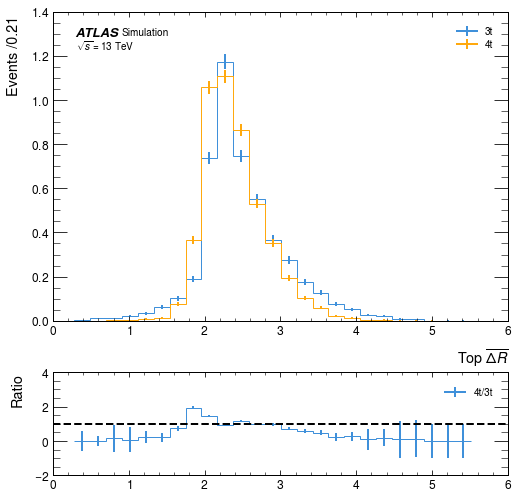

In [302]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaR_3t,deltaR_4t], 25, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $\overline{\Delta R}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

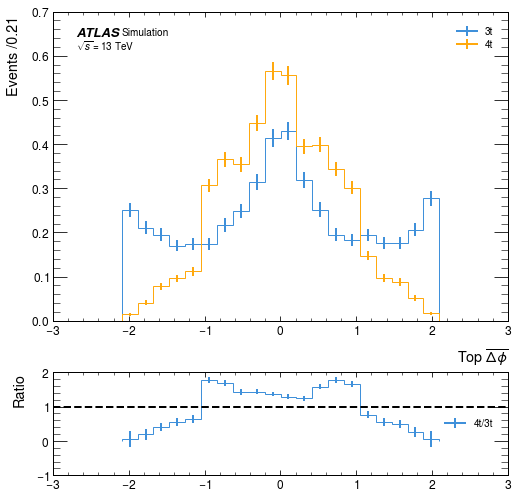

In [303]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaphi_3t,deltaphi_4t], 20, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $\overline{\Delta \phi}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

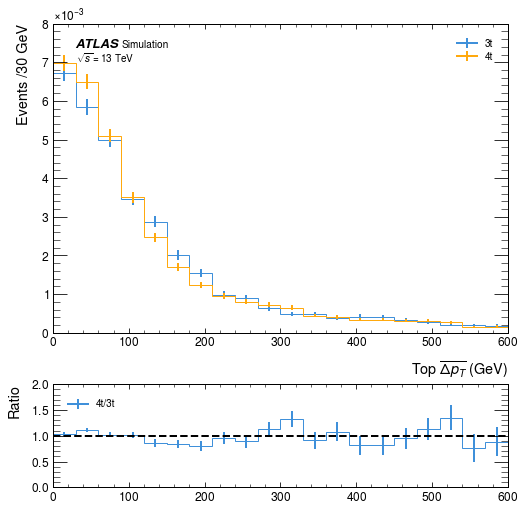

In [315]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltapt_3t,deltapt_4t], 20, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='GeV', set_range=(0,600))
ax[0].set_xlabel(r'Top $\overline{\Delta p_T}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

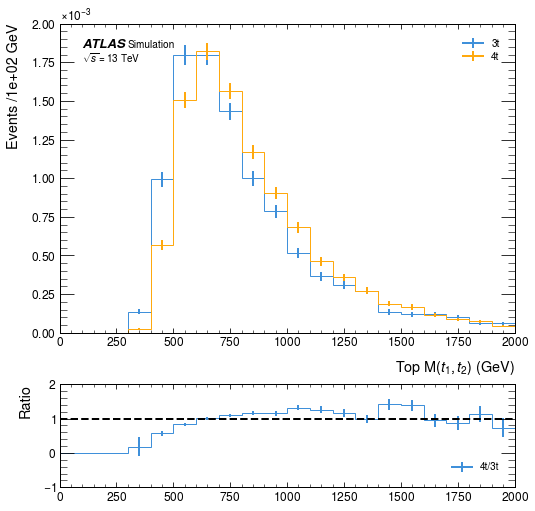

In [317]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([duo_masses_3t,duo_masses_4t], 20, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='GeV', set_range=(0,2000))
ax[0].set_xlabel(r'Top M($t_1,t_2$) (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

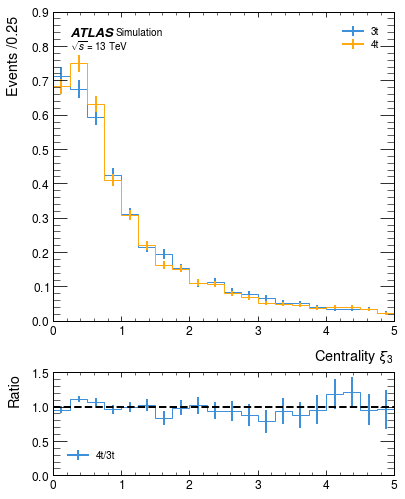

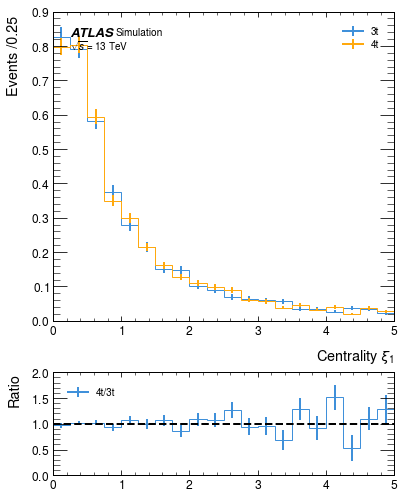

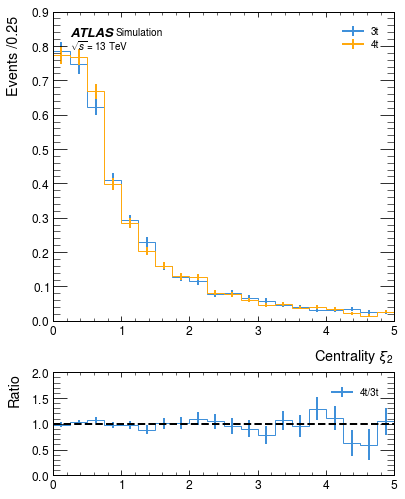

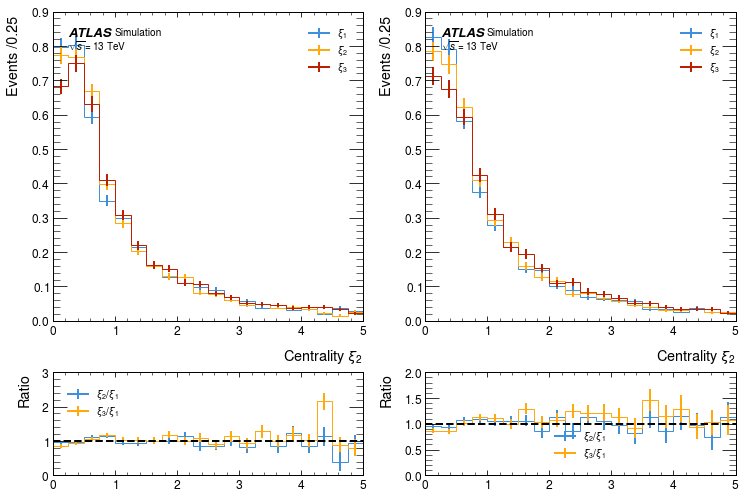

In [319]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3,1]},figsize = (6,8))
histogram([centrality_3_3t, centrality_3_4t], 20, ['3t', '4t'], ax[0], density = True, set_range=(0,5), ratio=True, ratio_axes=ax[1], x_units='')
ax[0].set_xlabel(r'Centrality $\xi_3$')
fig.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([centrality_1_3t, centrality_1_4t], 20, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,5), x_units='')
ax[0].set_xlabel(r'Centrality $\xi_1$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([centrality_2_3t, centrality_2_4t], 20, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,5), x_units='')
ax[0].set_xlabel(r'Centrality $\xi_2$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (12,8))
histogram([centrality_1_4t, centrality_2_4t, centrality_3_4t], 20, [r'$\xi_1$', r'$\xi_2$', r'$\xi_3$'], ax[0,0], density = True, ratio=True, ratio_axes=ax[1,0], set_range=(0,5), x_units='')
ax[0,0].set_xlabel(r'Centrality $\xi_2$')
histogram([centrality_1_3t, centrality_2_3t, centrality_3_3t], 20, [r'$\xi_1$', r'$\xi_2$', r'$\xi_3$'], ax[0,1], density = True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5), x_units='')
ax[0,1].set_xlabel(r'Centrality $\xi_2$')
plt.subplots_adjust(hspace=0.25)
plt.show()

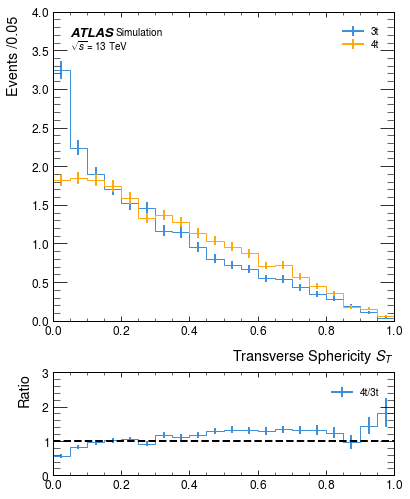

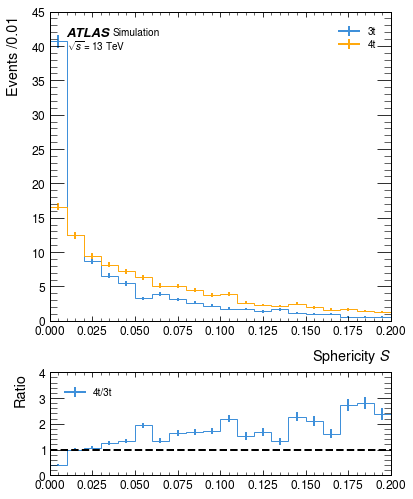

In [321]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([transverse_sphericity_3t, transverse_sphericity_4t], 20, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Transverse Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_3t, sphericity_4t], 20, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,0.2), x_units='')
ax[0].set_xlabel(r'Sphericity $S$')
plt.subplots_adjust(hspace=0.25)
plt.show()

# Possible Code for use later

In [ ]:
truth_level_numbers = list(dict.fromkeys(ak.num(truth_4t_test)))

truth_4t_dict = {}
reco_4t_dict = {}

for truth_number in truth_level_numbers:
    truth_4t_dict[f'truth_particles_{truth_number}'] = truth_4t_test[ak.num(truth_4t_test)==truth_number]
    reco_4t_dict[f'truth_particles_{truth_number}'] = reco_4t_test[ak.num(truth_4t_test)==truth_number]

for key in truth_4t_dict.keys():
    truth_particles = truth_4t_dict[key]
    reco_particles = reco_4t_dict[key]
    num = ak.num(truth_particles)[0]
    pairs = ak.cartesian({'truth':truth_particles,'reco':reco_particles})
    pairs = ak.unflatten(pairs, num, axis=1)
    deltars = pairs['reco'].deltaR(pairs['truth'])
    print(np.shape(pairs['truth'][1]))
    pairs = pairs[deltars == np.min(deltars, axis=1)]
    deltars = np.min(deltars, axis=1)
    pairs = pairs[deltars<0.4]
    print('Next Key')